# Projet 6 : Classifiez automatiquement des biens de consommation

## Contexte :

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

## Mission :

Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image.

## A noter :

PS : J’ai bien vérifié qu’il n’y avait aucune contrainte de propriété intellectuelle sur les données et les images.(Linda, Lead Data Scientist)


## Étape 1 : Étudiez la faisabilité de classification en utilisant des méthodes NLP basiques  

### 1.1 Prétraitement du texte

In [5]:
!pip install wordcloud

In [3]:
# Import des bibliothèques
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertModel
import tensorflow_hub as hub
import seaborn as sns

In [4]:
# Charger et afficher les données originales
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv') 
df

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [5]:
# Télécharger les stopwords et lemmatizer de NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# Charger les données 
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

# Reformatage de la colonne "product_category_tree"
data['product_category_tree'] = data['product_category_tree'].str.strip('["]')  # Enlever les crochets et guillemets
data['product_category_tree'] = data['product_category_tree'].str.split(' >> ')  # Diviser les chaînes de caractères

# Extraire les différentes catégories
data['category_lvl_1'] = data['product_category_tree'].apply(lambda x: x[0] if len(x) > 0 else None)
data['category_lvl_2'] = data['product_category_tree'].apply(lambda x: x[1] if len(x) > 1 else None)
data['category_lvl_3'] = data['product_category_tree'].apply(lambda x: x[2] if len(x) > 2 else None)

# La "main_category" sera notre cible
data['main_category'] = data['category_lvl_1']

# Supprimer les colonnes non nécessaires
columns_to_drop = [
    "crawl_timestamp",
    "product_url",
    "product_category_tree",
    "pid",
    "retail_price",
    "discounted_price",
    "is_FK_Advantage_product",
    "product_rating",
    "overall_rating",
    "product_specifications"
]
data.drop(columns=columns_to_drop, inplace=True)

# Initialiser les outils de prétraitement
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Fonction de nettoyage du texte
def preprocess_text(text):
    # Conversion en minuscules
    text = text.lower()
    # Supprimer les caractères spéciaux et chiffres
    text = re.sub(r'\W|\d', ' ', text)
    # Supprimer les stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    # Lemmatisation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

# Appliquer le prétraitement sur la colonne 'description' des produits
data['cleaned_text'] = (data['product_name'] + data['description']).apply(preprocess_text)
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SOUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SOUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                         description                  brand  \
0  Key Features of Elegance Polyester Multicolor ...               Elegance   
1  Specifications of Sathiyas Cotton Bath Towel (...               Sathiyas   
2  Key Features of Eurospa Cotton Terry Face Towe...                Eurospa   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  SANTOSH ROYAL FASHION   
4  Key Features of Jaipur Print Cotton Floral Kin...           Jaipur Print   

    category_lvl_1          category_lvl_2    category_lvl_3    main_category  \
0  Home Furnishing  Curtains & Accessories          Curtains  Home Furnishing   
1        Baby Care        Baby Bath & Skin  Baby Bath Towels        Baby Care   
2        Baby Care        Baby Bath & Skin  Baby Bath Towels        Baby Care   
3  Home Furnishing               Bed Linen         Bedsheets  Home Furnishing   
4  Home Furnishing               Bed Linen         Bedsheets  Home Furnishing   

                                        cleaned_text  
0  eleg polyest multicolor abstract eyelet door c...  
1  sathiya cotton bath towelspecif sathiya cotton...  
2  eurospa cotton terri face towel setkey featur ...  
3  santosh royal fashion cotton print king size d...  
4  jaipur print cotton floral king size doubl bed...

In [6]:
data['cleaned_text']

0       eleg polyest multicolor abstract eyelet door c...
1       sathiya cotton bath towelspecif sathiya cotton...
2       eurospa cotton terri face towel setkey featur ...
3       santosh royal fashion cotton print king size d...
4       jaipur print cotton floral king size doubl bed...
                              ...                        
1045    oren empow extra larg self adhes stickeroren e...
1046    wallmantra larg vinyl sticker stickerwallmantr...
1047    uberlyf extra larg pigment polyvinyl film impo...
1048    wallmantra medium vinyl sticker stickerbuy wal...
1049    uberlyf larg vinyl stickerbuy uberlyf larg vin...
Name: cleaned_text, Length: 1050, dtype: object

In [7]:
# Récupération du corpus
corpus = ' '.join(data['cleaned_text'])

In [8]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SOUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# Tokenisation
tokens = word_tokenize(corpus)

In [10]:
# Calcul des fréquences des termes
freq_dist = FreqDist(tokens)

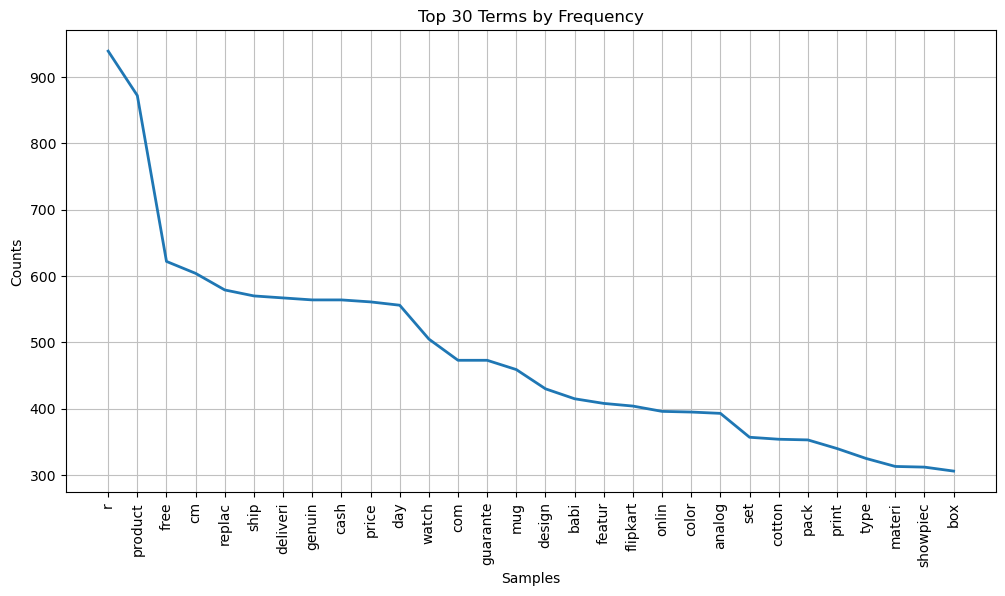

In [11]:
# Visualisation des termes les plus fréquents
plt.figure(figsize=(12, 6))
# Utilisez plot() directement avec les arguments nécessaires pour éviter les graphiques multiples
freq_dist.plot(30, title='Top 30 Terms by Frequency', cumulative=False)
plt.show()

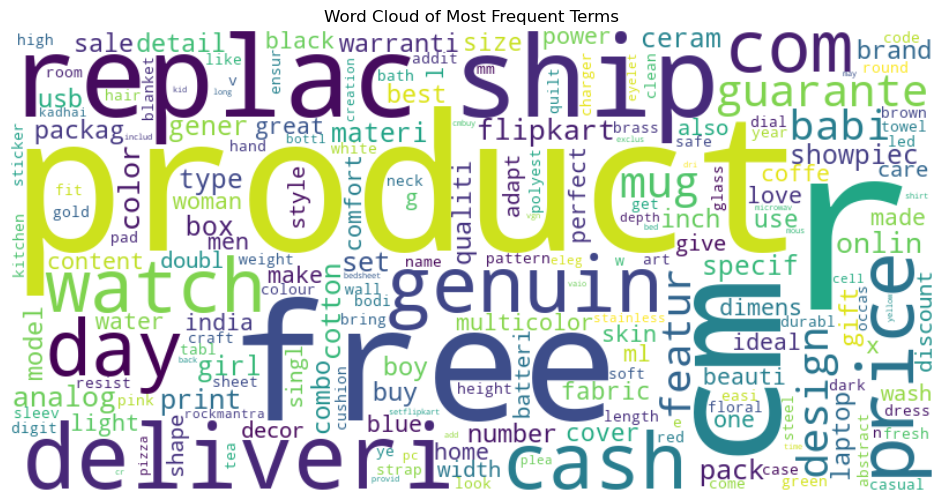

In [12]:
# Visualisation avec WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Terms')
plt.show()

In [13]:
# Nombre de mots avant suppression
num_tokens_before = len(tokens)
print(f'Number of tokens before removal: {num_tokens_before}')

Number of tokens before removal: 62592


In [14]:
# Suppression des mots d'une seule lettre
filtered_tokens = [word for word in tokens if len(word) > 1]

In [15]:
# Nombre de mots après suppression
num_tokens_after = len(filtered_tokens)
print(f'Number of tokens after removal: {num_tokens_after}')

Number of tokens after removal: 60609


In [16]:
# Calcul des fréquences des termes
freq_dist = FreqDist(filtered_tokens)

In [17]:
freq_dist

FreqDist({'product': 872, 'free': 622, 'cm': 604, 'replac': 579, 'ship': 570, 'deliveri': 567, 'genuin': 564, 'cash': 564, 'price': 561, 'day': 556, ...})

In [18]:
# enregistrer ma nouvelle dataframe nettoyée
data.to_csv('data.csv', index=False)

In [19]:
data

uniq_id  \
0     55b85ea15a1536d46b7190ad6fff8ce7   
1     7b72c92c2f6c40268628ec5f14c6d590   
2     64d5d4a258243731dc7bbb1eef49ad74   
3     d4684dcdc759dd9cdf41504698d737d8   
4     6325b6870c54cd47be6ebfbffa620ec7   
...                                ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc   
1046  fd6cbcc22efb6b761bd564c28928483c   
1047  5912e037d12774bb73a2048f35a00009   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6   
1049  f2f027ad6a6df617c9f125173da71e44   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                      brand   category_lvl_1          category_lvl_2  \
0                  Elegance  Home Furnishing  Curtains & Accessories   
1                  Sathiyas        Baby Care        Baby Bath & Skin   
2                   Eurospa        Baby Care        Baby Bath & Skin   
3     SANTOSH ROYAL FASHION  Home Furnishing               Bed Linen   
4              Jaipur Print  Home Furnishing               Bed Linen   
...                     ...              ...                     ...   
1045           Oren Empower        Baby Care       Baby & Kids Gifts   
1046             Wallmantra        Baby Care       Baby & Kids Gifts   
1047               Uberlyfe        Baby Care       Baby & Kids Gifts   
1048             Wallmantra        Baby Care       Baby & Kids Gifts   
1049               Uberlyfe        Baby Care       Baby & Kids Gifts   

        category_lvl_3    main_category  \
0             Curtains  Home Furnishing   
1     Baby Bath Towels        Baby Care   
2     Baby Bath Towels        Baby Care   
3            Bedsheets  Home Furnishing   
4            Bedsheets  Home Furnishing   
...                ...              ...   
1045          Stickers        Baby Care   
1046          Stickers        Baby Care   
1047          Stickers        Baby Care   
1048          Stickers        Baby Care   
1049          Stickers        Baby Care   

                                           cleaned_text  
0     eleg polyest multicolor abstract eyelet door c...  
1     sathiya cotton bath towelspecif sathiya cotton...  

### 1.2 Encodage du texte (Bag of Words , TF-IDF et LDA)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words (BoW)
vectorizer_bow = CountVectorizer(max_features=500)  # Limiter à 500 mots
X_bow = vectorizer_bow.fit_transform(data['cleaned_text']).toarray()

# TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=500)  # Limiter à 500 mots
X_tfidf = vectorizer_tfidf.fit_transform(data['cleaned_text']).toarray()

# Afficher la matrice BoW et TF-IDF
print("Bag of Words (BoW):", X_bow.shape)
print("TF-IDF:", X_tfidf.shape)

Bag of Words (BoW): (1050, 500)
TF-IDF: (1050, 500)


In [40]:
X_bow

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [42]:
X_tfidf

array([[0.22206481, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.18432901, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [37]:
from gensim import corpora, models
import pyLDAvis.gensim_models
# Application de LDA
dictionary = corpora.Dictionary([text.split() for text in data['cleaned_text']])
corpus = [dictionary.doc2bow(text.split()) for text in data['cleaned_text']]
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
# Extraire les distributions des sujets pour chaque document
lda_topics = lda_model.get_document_topics(corpus)
lda_topic_distributions = [dict(topic) for topic in lda_topics]
lda_topic_matrix = pd.DataFrame(lda_topic_distributions).fillna(0).values

In [39]:
# Réduction de la dimensionnalité (PCA et t-SNE)

# Assigner des couleurs uniques à chaque catégorie dans 'main_category'
categories = data['main_category'].unique()  # Trouver les catégories uniques
category_codes, category_labels = data['main_category'].factorize()  # Convertir les catégories en codes numériques
palette = sns.color_palette("hsv", len(categories))

# PCA pour la réduction de dimension
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf)

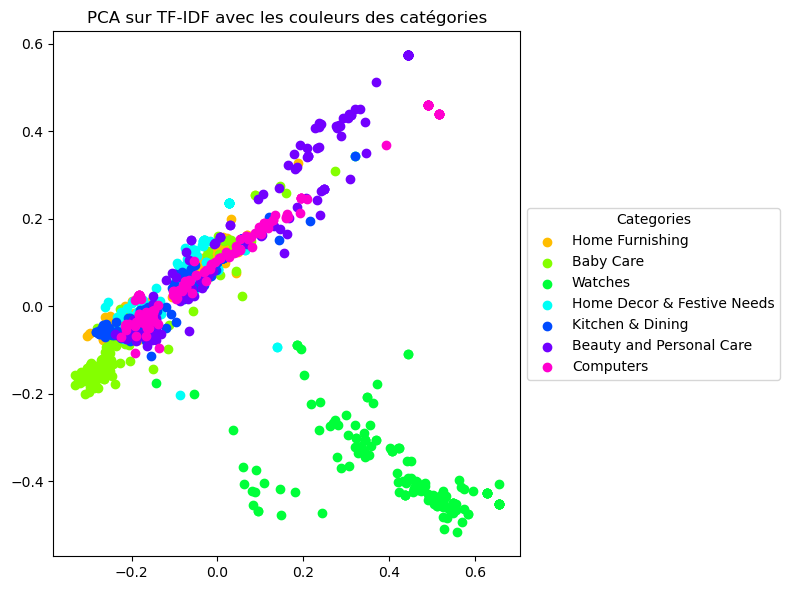

In [40]:
# Visualisation avec PCA (TF-IDF)
plt.figure(figsize=(8, 6))
for i, category in enumerate(categories):
    indices = category_codes == i
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=category, color=palette[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('PCA sur TF-IDF avec les couleurs des catégories')
plt.tight_layout()
plt.show()

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


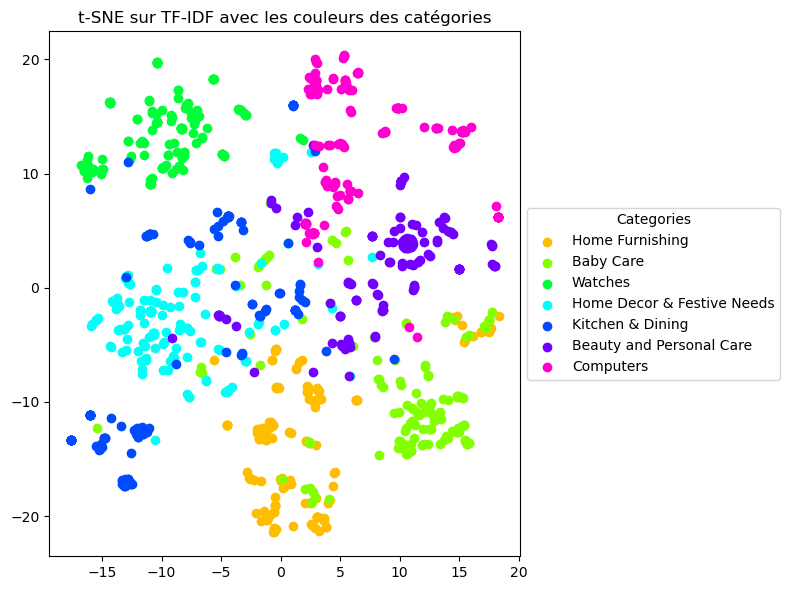

In [41]:
# t-SNE pour la réduction de dimension
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_tfidf)

# Visualisation avec t-SNE (TF-IDF)
plt.figure(figsize=(8, 6))
for i, category in enumerate(categories):
    indices = category_codes == i
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=category, color=palette[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('t-SNE sur TF-IDF avec les couleurs des catégories')
plt.tight_layout()
plt.show()

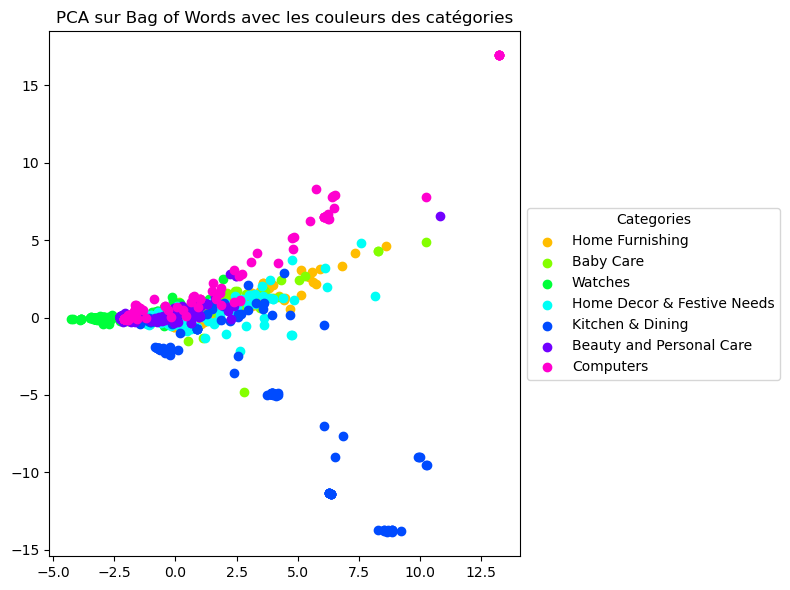

In [42]:
# PCA pour la réduction de dimension avec Bag of Words
pca_bow = PCA(n_components=2)
X_pca_bow = pca_bow.fit_transform(X_bow)

# Visualisation avec PCA (Bag of Words)
plt.figure(figsize=(8, 6))
for i, category in enumerate(categories):
    indices = category_codes == i
    plt.scatter(X_pca_bow[indices, 0], X_pca_bow[indices, 1], label=category, color=palette[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('PCA sur Bag of Words avec les couleurs des catégories')
plt.tight_layout()
plt.show()

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


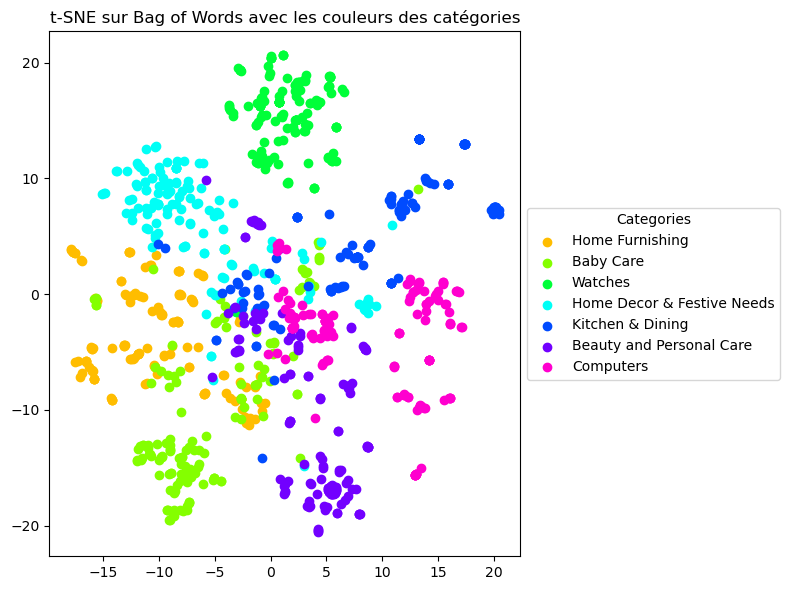

In [43]:

# t-SNE pour la réduction de dimension avec Bag of Words
tsne_bow = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne_bow = tsne_bow.fit_transform(X_bow)

# Visualisation avec t-SNE (Bag of Words)
plt.figure(figsize=(8, 6))
for i, category in enumerate(categories):
    indices = category_codes == i
    plt.scatter(X_tsne_bow[indices, 0], X_tsne_bow[indices, 1], label=category, color=palette[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('t-SNE sur Bag of Words avec les couleurs des catégories')
plt.tight_layout()
plt.show()

In [44]:
from gensim import corpora, models

# Pour Bag of Words
dictionary_bow = corpora.Dictionary([text.split() for text in data['cleaned_text']])
corpus_bow = [dictionary_bow.doc2bow(text.split()) for text in data['cleaned_text']]
lda_model_bow = models.LdaModel(corpus_bow, num_topics=5, id2word=dictionary_bow, passes=15)

# Pour TF-IDF
dictionary_tfidf = corpora.Dictionary([text.split() for text in data['cleaned_text']])
corpus_tfidf = [dictionary_tfidf.doc2bow(text.split()) for text in data['cleaned_text']]
lda_model_tfidf = models.LdaModel(corpus_tfidf, num_topics=5, id2word=dictionary_tfidf, passes=15)

# Extraire les distributions des sujets pour chaque document (Bag of Words et TF-IDF)
lda_topics_bow = lda_model_bow.get_document_topics(corpus_bow)
lda_topics_tfidf = lda_model_tfidf.get_document_topics(corpus_tfidf)

# Convertir les distributions en matrices exploitables par PCA ou t-SNE
lda_topic_matrix_bow = pd.DataFrame([{k: v for k, v in doc} for doc in lda_topics_bow]).fillna(0).values
lda_topic_matrix_tfidf = pd.DataFrame([{k: v for k, v in doc} for doc in lda_topics_tfidf]).fillna(0).values

In [45]:
# Appliquer PCA sur les résultats de LDA (Bag of Words)
pca_bow_lda = PCA(n_components=2)
X_pca_bow_lda = pca_bow_lda.fit_transform(lda_topic_matrix_bow)

# Appliquer PCA sur les résultats de LDA (TF-IDF)
pca_tfidf_lda = PCA(n_components=2)
X_pca_tfidf_lda = pca_tfidf_lda.fit_transform(lda_topic_matrix_tfidf)

# Appliquer t-SNE sur les résultats de LDA (Bag of Words)
tsne_bow_lda = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne_bow_lda = tsne_bow_lda.fit_transform(lda_topic_matrix_bow)

# Appliquer t-SNE sur les résultats de LDA (TF-IDF)
tsne_tfidf_lda = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne_tfidf_lda = tsne_tfidf_lda.fit_transform(lda_topic_matrix_tfidf)

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


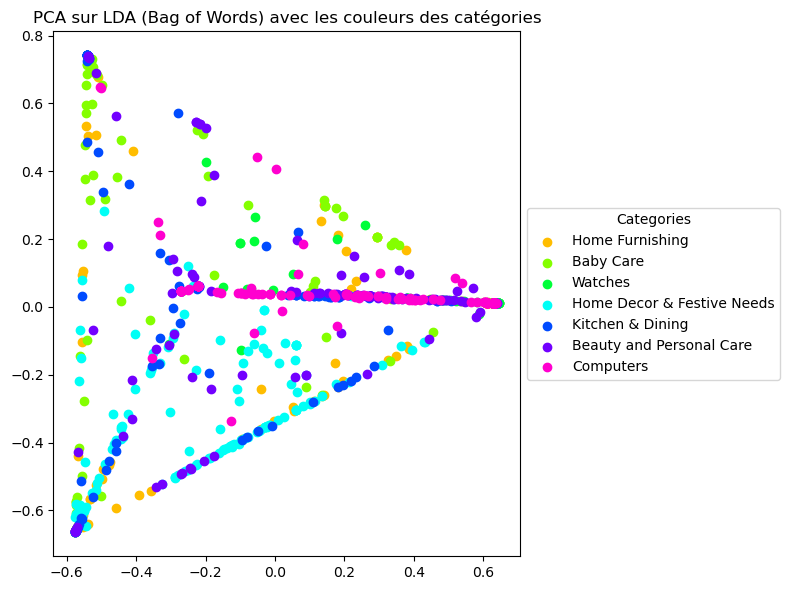

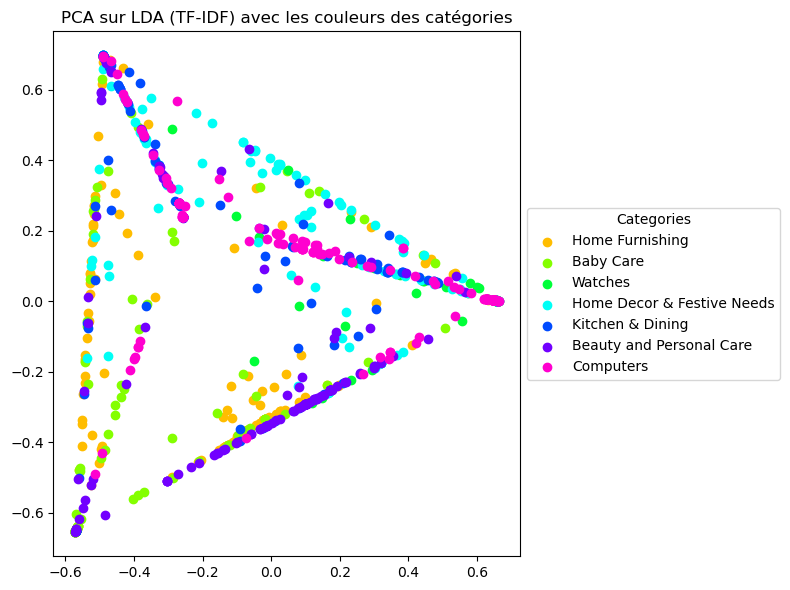

In [46]:
import matplotlib.pyplot as plt

# Visualisation avec PCA (LDA sur Bag of Words)
plt.figure(figsize=(8, 6))
for i, category in enumerate(categories):
    indices = category_codes == i
    plt.scatter(X_pca_bow_lda[indices, 0], X_pca_bow_lda[indices, 1], label=category, color=palette[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('PCA sur LDA (Bag of Words) avec les couleurs des catégories')
plt.tight_layout()
plt.show()

# Visualisation avec PCA (LDA sur TF-IDF)
plt.figure(figsize=(8, 6))
for i, category in enumerate(categories):
    indices = category_codes == i
    plt.scatter(X_pca_tfidf_lda[indices, 0], X_pca_tfidf_lda[indices, 1], label=category, color=palette[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('PCA sur LDA (TF-IDF) avec les couleurs des catégories')
plt.tight_layout()
plt.show()

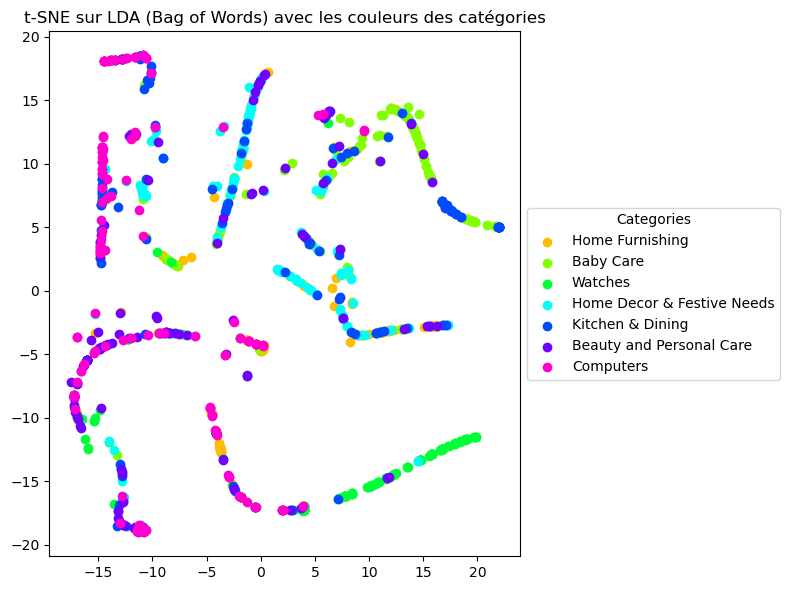

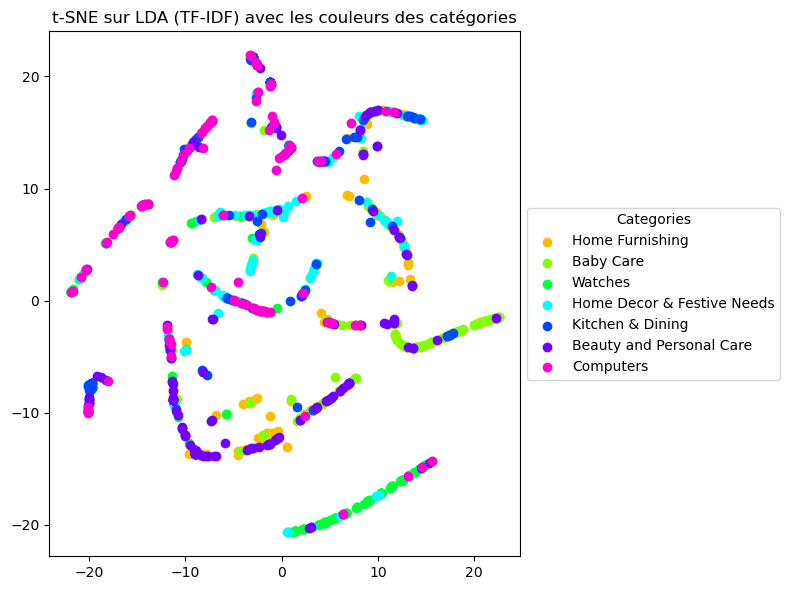

In [47]:
# Visualisation avec t-SNE (LDA sur Bag of Words)
plt.figure(figsize=(8, 6))
for i, category in enumerate(categories):
    indices = category_codes == i
    plt.scatter(X_tsne_bow_lda[indices, 0], X_tsne_bow_lda[indices, 1], label=category, color=palette[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('t-SNE sur LDA (Bag of Words) avec les couleurs des catégories')
plt.tight_layout()
plt.show()

# Visualisation avec t-SNE (LDA sur TF-IDF)
plt.figure(figsize=(8, 6))
for i, category in enumerate(categories):
    indices = category_codes == i
    plt.scatter(X_tsne_tfidf_lda[indices, 0], X_tsne_tfidf_lda[indices, 1], label=category, color=palette[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('t-SNE sur LDA (TF-IDF) avec les couleurs des catégories')
plt.tight_layout()
plt.show()

In [48]:
import matplotlib.pyplot as plt

# Afficher les top termes pour chaque sujet
for topic_id in range(lda_model.num_topics):
    print(f"Top terms for Topic {topic_id}:")
    terms = lda_model.show_topic(topic_id, topn=10)
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")
    print()

Top terms for Topic 0:
  mug: 0.0208
  coffe: 0.0188
  led: 0.0145
  usb: 0.0141
  tea: 0.0133
  price: 0.0112
  light: 0.0111
  perfect: 0.0110
  one: 0.0109
  ceram: 0.0098

Top terms for Topic 1:
  laptop: 0.0134
  warranti: 0.0132
  color: 0.0112
  inch: 0.0104
  featur: 0.0103
  type: 0.0100
  model: 0.0098
  skin: 0.0095
  product: 0.0094
  box: 0.0084

Top terms for Topic 2:
  babi: 0.0299
  cotton: 0.0222
  girl: 0.0180
  detail: 0.0143
  print: 0.0139
  fabric: 0.0136
  r: 0.0111
  boy: 0.0101
  singl: 0.0095
  price: 0.0091

Top terms for Topic 3:
  free: 0.0305
  r: 0.0304
  ship: 0.0303
  deliveri: 0.0302
  cash: 0.0302
  genuin: 0.0302
  product: 0.0285
  watch: 0.0275
  guarante: 0.0261
  com: 0.0261

Top terms for Topic 4:
  cm: 0.0223
  design: 0.0122
  ceram: 0.0108
  featur: 0.0107
  materi: 0.0098
  mug: 0.0094
  showpiec: 0.0093
  price: 0.0093
  gift: 0.0090
  r: 0.0086



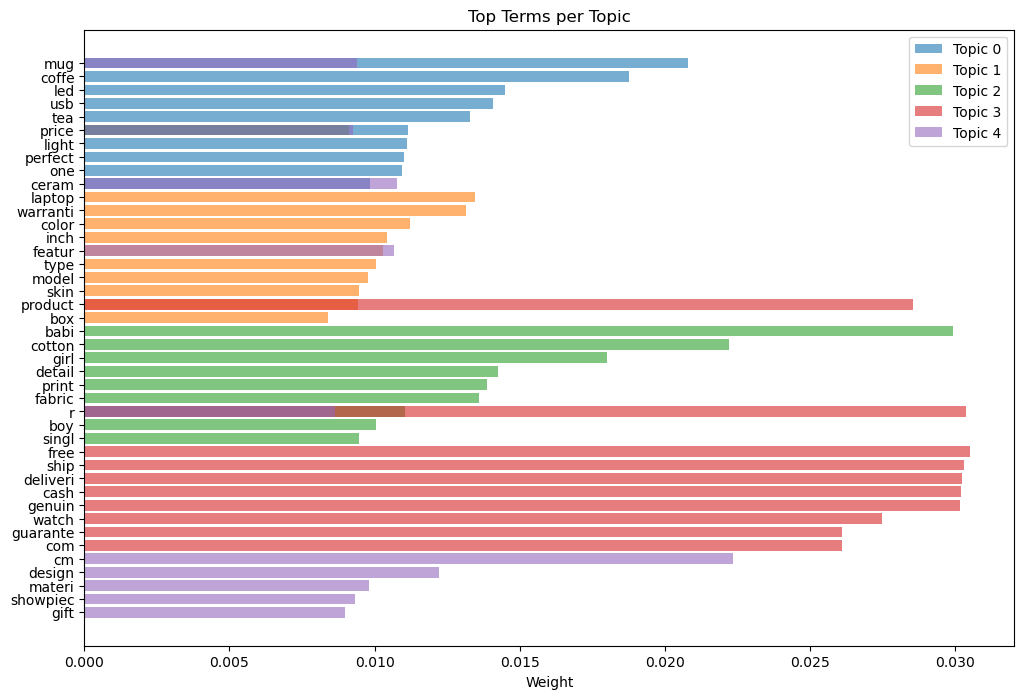

In [49]:
# Visualiser les principaux termes pour chaque sujet :
#Vous pouvez afficher les termes les plus importants pour chaque sujet pour avoir une idée de ce que chaque sujet représente.import matplotlib.pyplot as plt
import pandas as pd

# Nombre de sujets
num_topics = lda_model.num_topics

# Préparer une figure
plt.figure(figsize=(12, 8))

# Visualiser les principaux termes pour chaque sujet
for topic_id in range(num_topics):
    terms = lda_model.show_topic(topic_id, topn=10)
    terms_df = pd.DataFrame(terms, columns=['Term', 'Weight'])
    terms_df['Topic'] = topic_id
    
    plt.barh(terms_df['Term'], terms_df['Weight'], label=f'Topic {topic_id}', alpha=0.6)

plt.xlabel('Weight')
plt.title('Top Terms per Topic')
plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.show()

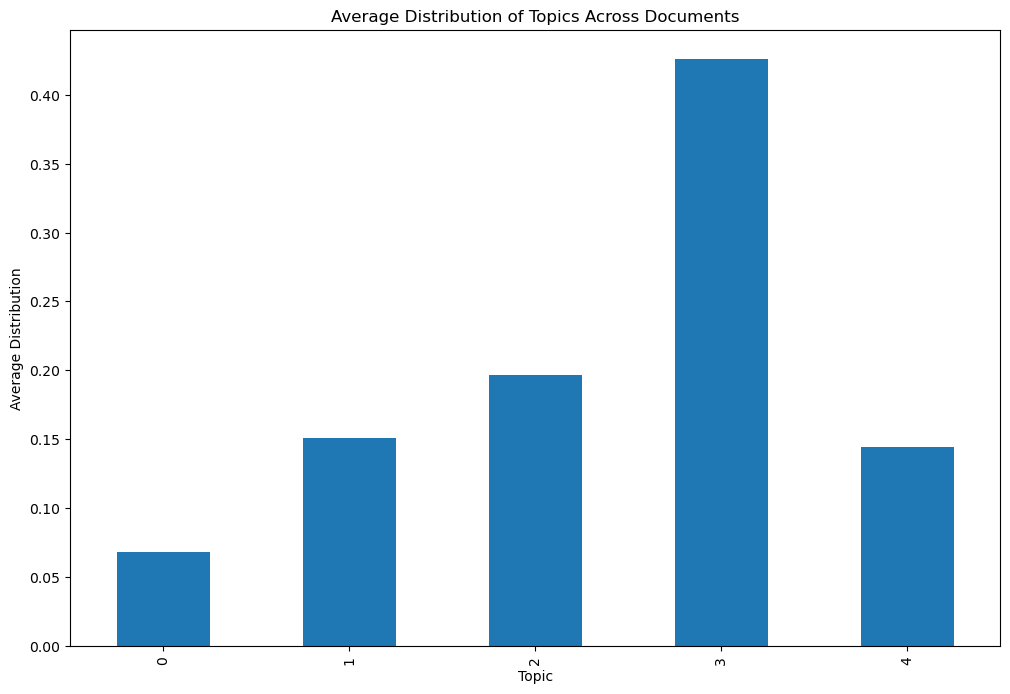

In [50]:
# Visualiser la distribution des sujets pour les documents :
# Vous pouvez également visualiser comment les sujets sont distribués parmi les documents.

import numpy as np

# Créer un DataFrame avec les distributions de sujets
topic_distributions = pd.DataFrame(lda_topic_distributions).fillna(0)

# Visualiser les distributions de sujets
plt.figure(figsize=(12, 8))
topic_distributions.mean().plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Average Distribution')
plt.title('Average Distribution of Topics Across Documents')
plt.show()

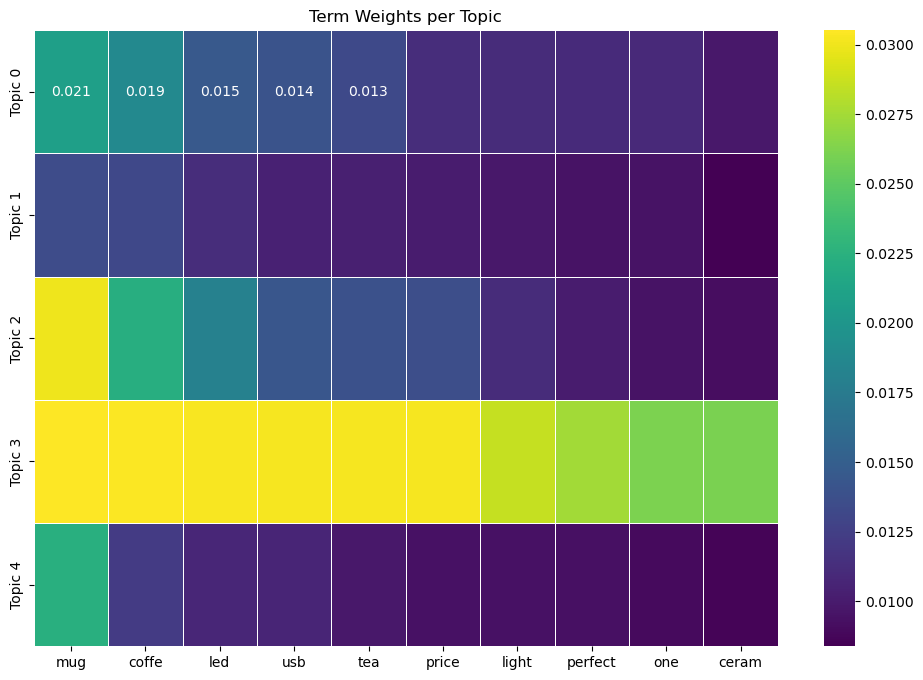

In [51]:
# 3. Visualiser la matrice de termes par sujet :
# Pour une vue plus complète, vous pouvez créer une heatmap des termes par sujet.
import seaborn as sns

# Créer une DataFrame pour la heatmap
terms_per_topic = pd.DataFrame([[term[1] for term in lda_model.show_topic(topic_id, topn=10)] for topic_id in range(num_topics)],
                               columns=[term[0] for term in lda_model.show_topic(0, topn=10)],
                               index=[f'Topic {i}' for i in range(num_topics)])

# Visualiser la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(terms_per_topic, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Term Weights per Topic')
plt.show()

### 1.3 évaluation de a qualité de clustering avec le différentes méthodes 

In [70]:
from sklearn.decomposition import LatentDirichletAllocation

# Application de LDA sur les données Bag of Words (BoW)
lda_bow = LatentDirichletAllocation(n_components=7, random_state=42)  # n_components correspond au nombre de catégories
X_bow_lda = lda_bow.fit_transform(X_bow)

# Application de LDA sur les données TF-IDF
lda_tfidf = LatentDirichletAllocation(n_components=7, random_state=42)
X_tfidf_lda = lda_tfidf.fit_transform(X_tfidf)

In [72]:
# Encodage des catégories réelles
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(data['main_category'])

# Réduction de dimension avec PCA
pca_bow = PCA(n_components=2)
X_bow_pca = pca_bow.fit_transform(X_bow)

pca_tfidf = PCA(n_components=2)
X_tfidf_pca = pca_tfidf.fit_transform(X_tfidf)

# Application de LDA
lda_bow = LatentDirichletAllocation(n_components=7, random_state=42)
X_bow_lda = lda_bow.fit_transform(X_bow)

lda_tfidf = LatentDirichletAllocation(n_components=7, random_state=42)
X_tfidf_lda = lda_tfidf.fit_transform(X_tfidf)

# Réduction de dimension avec PCA après LDA
pca_lda_bow = PCA(n_components=2)
X_lda_bow_pca = pca_lda_bow.fit_transform(X_bow_lda)

pca_lda_tfidf = PCA(n_components=2)
X_lda_tfidf_pca = pca_lda_tfidf.fit_transform(X_tfidf_lda)

# Réduction de dimension avec t-SNE
tsne_bow = TSNE(n_components=2, perplexity=30, n_iter=300)
X_bow_tsne = tsne_bow.fit_transform(X_bow)

tsne_tfidf = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tfidf_tsne = tsne_tfidf.fit_transform(X_tfidf)

tsne_lda_bow = TSNE(n_components=2, perplexity=30, n_iter=300)
X_lda_bow_tsne = tsne_lda_bow.fit_transform(X_bow_lda)

tsne_lda_tfidf = TSNE(n_components=2, perplexity=30, n_iter=300)
X_lda_tfidf_tsne = tsne_lda_tfidf.fit_transform(X_tfidf_lda)

# Calcul des métriques de qualité

# Silhouette Score
silhouette_pca_bow = silhouette_score(X_bow_pca, y_true)
silhouette_pca_tfidf = silhouette_score(X_tfidf_pca, y_true)
silhouette_pca_lda_bow = silhouette_score(X_lda_bow_pca, y_true)
silhouette_pca_lda_tfidf = silhouette_score(X_lda_tfidf_pca, y_true)

silhouette_tsne_bow = silhouette_score(X_bow_tsne, y_true)
silhouette_tsne_tfidf = silhouette_score(X_tfidf_tsne, y_true)
silhouette_tsne_lda_bow = silhouette_score(X_lda_bow_tsne, y_true)
silhouette_tsne_lda_tfidf = silhouette_score(X_lda_tfidf_tsne, y_true)

# Davies-Bouldin Index
dbi_pca_bow = davies_bouldin_score(X_bow_pca, y_true)
dbi_pca_tfidf = davies_bouldin_score(X_tfidf_pca, y_true)
dbi_pca_lda_bow = davies_bouldin_score(X_lda_bow_pca, y_true)
dbi_pca_lda_tfidf = davies_bouldin_score(X_lda_tfidf_pca, y_true)

dbi_tsne_bow = davies_bouldin_score(X_bow_tsne, y_true)
dbi_tsne_tfidf = davies_bouldin_score(X_tfidf_tsne, y_true)
dbi_tsne_lda_bow = davies_bouldin_score(X_lda_bow_tsne, y_true)
dbi_tsne_lda_tfidf = davies_bouldin_score(X_lda_tfidf_tsne, y_true)

# Affichage des résultats
print(f"Silhouette Score (PCA - Bag of Words): {silhouette_pca_bow:.3f}")
print(f"Silhouette Score (PCA - TF-IDF): {silhouette_pca_tfidf:.3f}")
print(f"Silhouette Score (PCA - LDA - Bag of Words): {silhouette_pca_lda_bow:.3f}")
print(f"Silhouette Score (PCA - LDA - TF-IDF): {silhouette_pca_lda_tfidf:.3f}")

print(f"Silhouette Score (t-SNE - Bag of Words): {silhouette_tsne_bow:.3f}")
print(f"Silhouette Score (t-SNE - TF-IDF): {silhouette_tsne_tfidf:.3f}")
print(f"Silhouette Score (t-SNE - LDA - Bag of Words): {silhouette_tsne_lda_bow:.3f}")
print(f"Silhouette Score (t-SNE - LDA - TF-IDF): {silhouette_tsne_lda_tfidf:.3f}")

print(f"Davies-Bouldin Index (PCA - Bag of Words): {dbi_pca_bow:.3f}")
print(f"Davies-Bouldin Index (PCA - TF-IDF): {dbi_pca_tfidf:.3f}")
print(f"Davies-Bouldin Index (PCA - LDA - Bag of Words): {dbi_pca_lda_bow:.3f}")
print(f"Davies-Bouldin Index (PCA - LDA - TF-IDF): {dbi_pca_lda_tfidf:.3f}")

print(f"Davies-Bouldin Index (t-SNE - Bag of Words): {dbi_tsne_bow:.3f}")
print(f"Davies-Bouldin Index (t-SNE - TF-IDF): {dbi_tsne_tfidf:.3f}")
print(f"Davies-Bouldin Index (t-SNE - LDA - Bag of Words): {dbi_tsne_lda_bow:.3f}")
print(f"Davies-Bouldin Index (t-SNE - LDA - TF-IDF): {dbi_tsne_lda_tfidf:.3f}")

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: Future

Silhouette Score (PCA - Bag of Words): -0.118
Silhouette Score (PCA - TF-IDF): -0.015
Silhouette Score (PCA - LDA - Bag of Words): -0.087
Silhouette Score (PCA - LDA - TF-IDF): -0.018
Silhouette Score (t-SNE - Bag of Words): 0.212
Silhouette Score (t-SNE - TF-IDF): 0.231
Silhouette Score (t-SNE - LDA - Bag of Words): -0.013
Silhouette Score (t-SNE - LDA - TF-IDF): 0.013
Davies-Bouldin Index (PCA - Bag of Words): 8.483
Davies-Bouldin Index (PCA - TF-IDF): 9.088
Davies-Bouldin Index (PCA - LDA - Bag of Words): 6.801
Davies-Bouldin Index (PCA - LDA - TF-IDF): 5.106
Davies-Bouldin Index (t-SNE - Bag of Words): 1.856
Davies-Bouldin Index (t-SNE - TF-IDF): 2.204
Davies-Bouldin Index (t-SNE - LDA - Bag of Words): 5.857
Davies-Bouldin Index (t-SNE - LDA - TF-IDF): 10.242


In [73]:
# Réduction de dimension avec PCA
pca_bow = PCA(n_components=2)
X_bow_pca = pca_bow.fit_transform(X_bow)

pca_tfidf = PCA(n_components=2)
X_tfidf_pca = pca_tfidf.fit_transform(X_tfidf)

pca_lda_bow = PCA(n_components=2)
X_lda_bow_pca = pca_lda_bow.fit_transform(X_bow_lda)

pca_lda_tfidf = PCA(n_components=2)
X_lda_tfidf_pca = pca_lda_tfidf.fit_transform(X_tfidf_lda)

In [74]:
# Réduction de dimension avec t-SNE
tsne_bow = TSNE(n_components=2, perplexity=30, n_iter=300)
X_bow_tsne = tsne_bow.fit_transform(X_bow)

tsne_tfidf = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tfidf_tsne = tsne_tfidf.fit_transform(X_tfidf)

tsne_lda_bow = TSNE(n_components=2, perplexity=30, n_iter=300)
X_lda_bow_tsne = tsne_lda_bow.fit_transform(X_bow_lda)

tsne_lda_tfidf = TSNE(n_components=2, perplexity=30, n_iter=300)
X_lda_tfidf_tsne = tsne_lda_tfidf.fit_transform(X_tfidf_lda)


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: Future

In [75]:
# Clustering avec KMeans
kmeans_bow = KMeans(n_clusters=7, random_state=42)
y_kmeans_bow_pca = kmeans_bow.fit_predict(X_bow_pca)
y_kmeans_tfidf_pca = kmeans_bow.fit_predict(X_tfidf_pca)
y_kmeans_lda_bow_pca = kmeans_bow.fit_predict(X_lda_bow_pca)
y_kmeans_lda_tfidf_pca = kmeans_bow.fit_predict(X_lda_tfidf_pca)

y_kmeans_bow_tsne = kmeans_bow.fit_predict(X_bow_tsne)
y_kmeans_tfidf_tsne = kmeans_bow.fit_predict(X_tfidf_tsne)
y_kmeans_lda_bow_tsne = kmeans_bow.fit_predict(X_lda_bow_tsne)
y_kmeans_lda_tfidf_tsne = kmeans_bow.fit_predict(X_lda_tfidf_tsne)


C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

In [76]:
# Calcul des métriques de qualité

# Silhouette Score
silhouette_pca_bow = silhouette_score(X_bow_pca, y_kmeans_bow_pca)
silhouette_pca_tfidf = silhouette_score(X_tfidf_pca, y_kmeans_tfidf_pca)
silhouette_pca_lda_bow = silhouette_score(X_lda_bow_pca, y_kmeans_lda_bow_pca)
silhouette_pca_lda_tfidf = silhouette_score(X_lda_tfidf_pca, y_kmeans_lda_tfidf_pca)

silhouette_tsne_bow = silhouette_score(X_bow_tsne, y_kmeans_bow_tsne)
silhouette_tsne_tfidf = silhouette_score(X_tfidf_tsne, y_kmeans_tfidf_tsne)
silhouette_tsne_lda_bow = silhouette_score(X_lda_bow_tsne, y_kmeans_lda_bow_tsne)
silhouette_tsne_lda_tfidf = silhouette_score(X_lda_tfidf_tsne, y_kmeans_lda_tfidf_tsne)

In [77]:
# Davies-Bouldin Index
dbi_pca_bow = davies_bouldin_score(X_bow_pca, y_kmeans_bow_pca)
dbi_pca_tfidf = davies_bouldin_score(X_tfidf_pca, y_kmeans_tfidf_pca)
dbi_pca_lda_bow = davies_bouldin_score(X_lda_bow_pca, y_kmeans_lda_bow_pca)
dbi_pca_lda_tfidf = davies_bouldin_score(X_lda_tfidf_pca, y_kmeans_lda_tfidf_pca)

dbi_tsne_bow = davies_bouldin_score(X_bow_tsne, y_kmeans_bow_tsne)
dbi_tsne_tfidf = davies_bouldin_score(X_tfidf_tsne, y_kmeans_tfidf_tsne)
dbi_tsne_lda_bow = davies_bouldin_score(X_lda_bow_tsne, y_kmeans_lda_bow_tsne)
dbi_tsne_lda_tfidf = davies_bouldin_score(X_lda_tfidf_tsne, y_kmeans_lda_tfidf_tsne)

In [78]:
from sklearn.metrics import adjusted_rand_score

# Adjusted Rand Index (ARI)
ari_pca_bow = adjusted_rand_score(y_true, y_kmeans_bow_pca)
ari_pca_tfidf = adjusted_rand_score(y_true, y_kmeans_tfidf_pca)
ari_pca_lda_bow = adjusted_rand_score(y_true, y_kmeans_lda_bow_pca)
ari_pca_lda_tfidf = adjusted_rand_score(y_true, y_kmeans_lda_tfidf_pca)

ari_tsne_bow = adjusted_rand_score(y_true, y_kmeans_bow_tsne)
ari_tsne_tfidf = adjusted_rand_score(y_true, y_kmeans_tfidf_tsne)
ari_tsne_lda_bow = adjusted_rand_score(y_true, y_kmeans_lda_bow_tsne)
ari_tsne_lda_tfidf = adjusted_rand_score(y_true, y_kmeans_lda_tfidf_tsne)


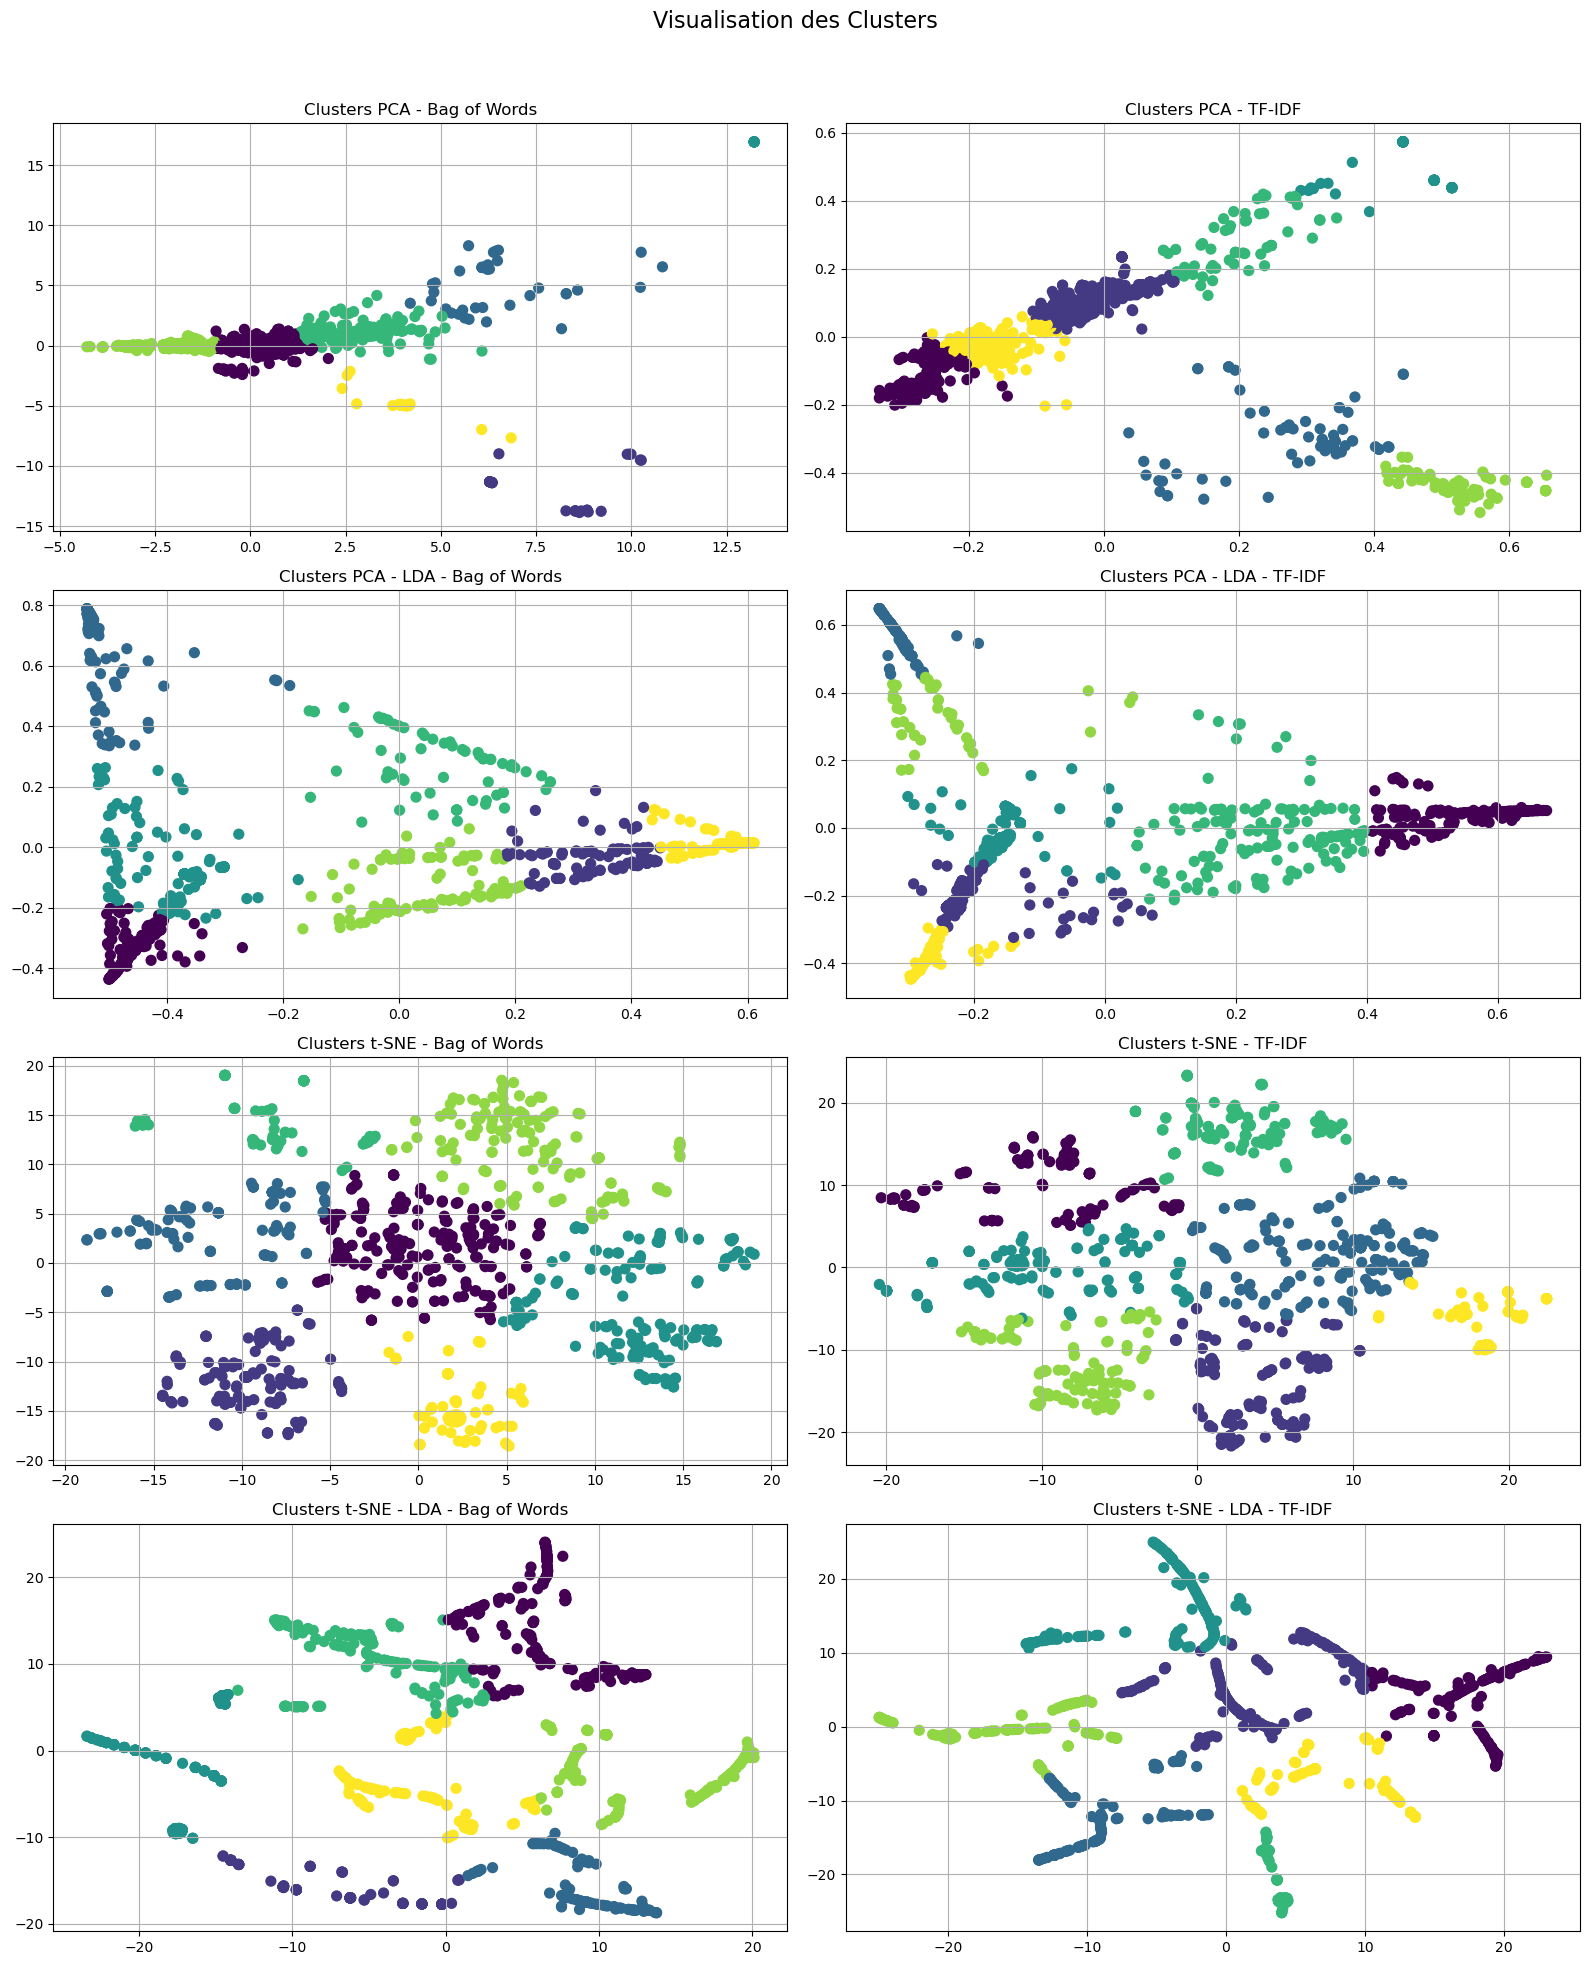

In [90]:
def plot_clusters_subplot(ax, X, y_kmeans, title):
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', s=50)
    ax.set_title(title)
    ax.grid(True)
    return scatter

# Création de la figure avec 4x2 subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle('Visualisation des Clusters', fontsize=16)

# Placer les graphiques dans les subplots
scatter1 = plot_clusters_subplot(axs[0, 0], X_bow_pca, y_kmeans_bow_pca, "Clusters PCA - Bag of Words")
scatter2 = plot_clusters_subplot(axs[0, 1], X_tfidf_pca, y_kmeans_tfidf_pca, "Clusters PCA - TF-IDF")
scatter3 = plot_clusters_subplot(axs[1, 0], X_lda_bow_pca, y_kmeans_lda_bow_pca, "Clusters PCA - LDA - Bag of Words")
scatter4 = plot_clusters_subplot(axs[1, 1], X_lda_tfidf_pca, y_kmeans_lda_tfidf_pca, "Clusters PCA - LDA - TF-IDF")
scatter5 = plot_clusters_subplot(axs[2, 0], X_bow_tsne, y_kmeans_bow_tsne, "Clusters t-SNE - Bag of Words")
scatter6 = plot_clusters_subplot(axs[2, 1], X_tfidf_tsne, y_kmeans_tfidf_tsne, "Clusters t-SNE - TF-IDF")
scatter7 = plot_clusters_subplot(axs[3, 0], X_lda_bow_tsne, y_kmeans_lda_bow_tsne, "Clusters t-SNE - LDA - Bag of Words")
scatter8 = plot_clusters_subplot(axs[3, 1], X_lda_tfidf_tsne, y_kmeans_lda_tfidf_tsne, "Clusters t-SNE - LDA - TF-IDF")

# Ajuster l'espacement entre les subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuster la position pour le titre principal

# Enregistrer l'image
plt.savefig("Clusters_methodes_basiques.png")

# Afficher l'image
plt.show()

In [157]:
# Affichage des résultats
print(f"Silhouette Score (PCA - Bag of Words): {silhouette_pca_bow:.3f}")
print(f"Silhouette Score (PCA - TF-IDF): {silhouette_pca_tfidf:.3f}")
print(f"Silhouette Score (PCA - LDA - Bag of Words): {silhouette_pca_lda_bow:.3f}")
print(f"Silhouette Score (PCA - LDA - TF-IDF): {silhouette_pca_lda_tfidf:.3f}")

print(f"Silhouette Score (t-SNE - Bag of Words): {silhouette_tsne_bow:.3f}")
print(f"Silhouette Score (t-SNE - TF-IDF): {silhouette_tsne_tfidf:.3f}")
print(f"Silhouette Score (t-SNE - LDA - Bag of Words): {silhouette_tsne_lda_bow:.3f}")
print(f"Silhouette Score (t-SNE - LDA - TF-IDF): {silhouette_tsne_lda_tfidf:.3f}")

print(f"Davies-Bouldin Index (PCA - Bag of Words): {dbi_pca_bow:.3f}")
print(f"Davies-Bouldin Index (PCA - TF-IDF): {dbi_pca_tfidf:.3f}")
print(f"Davies-Bouldin Index (PCA - LDA - Bag of Words): {dbi_pca_lda_bow:.3f}")
print(f"Davies-Bouldin Index (PCA - LDA - TF-IDF): {dbi_pca_lda_tfidf:.3f}")

print(f"Davies-Bouldin Index (t-SNE - Bag of Words): {dbi_tsne_bow:.3f}")
print(f"Davies-Bouldin Index (t-SNE - TF-IDF): {dbi_tsne_tfidf:.3f}")
print(f"Davies-Bouldin Index (t-SNE - LDA - Bag of Words): {dbi_tsne_lda_bow:.3f}")
print(f"Davies-Bouldin Index (t-SNE - LDA - TF-IDF): {dbi_tsne_lda_tfidf:.3f}")

print(f"Adjusted Rand Index (PCA - Bag of Words): {ari_pca_bow:.3f}")
print(f"Adjusted Rand Index (PCA - TF-IDF): {ari_pca_tfidf:.3f}")
print(f"Adjusted Rand Index (PCA - LDA - Bag of Words): {ari_pca_lda_bow:.3f}")
print(f"Adjusted Rand Index (PCA - LDA - TF-IDF): {ari_pca_lda_tfidf:.3f}")

print(f"Adjusted Rand Index (t-SNE - Bag of Words): {ari_tsne_bow:.3f}")
print(f"Adjusted Rand Index (t-SNE - TF-IDF): {ari_tsne_tfidf:.3f}")
print(f"Adjusted Rand Index (t-SNE - LDA - Bag of Words): {ari_tsne_lda_bow:.3f}")
print(f"Adjusted Rand Index (t-SNE - LDA - TF-IDF): {ari_tsne_lda_tfidf:.3f}")

Silhouette Score (PCA - Bag of Words): 0.571
Silhouette Score (PCA - TF-IDF): 0.497
Silhouette Score (PCA - LDA - Bag of Words): 0.633
Silhouette Score (PCA - LDA - TF-IDF): 0.606
Silhouette Score (t-SNE - Bag of Words): 0.456
Silhouette Score (t-SNE - TF-IDF): 0.425
Silhouette Score (t-SNE - LDA - Bag of Words): 0.455
Silhouette Score (t-SNE - LDA - TF-IDF): 0.453
Davies-Bouldin Index (PCA - Bag of Words): 0.514
Davies-Bouldin Index (PCA - TF-IDF): 0.657
Davies-Bouldin Index (PCA - LDA - Bag of Words): 0.562
Davies-Bouldin Index (PCA - LDA - TF-IDF): 0.563
Davies-Bouldin Index (t-SNE - Bag of Words): 0.712
Davies-Bouldin Index (t-SNE - TF-IDF): 0.823
Davies-Bouldin Index (t-SNE - LDA - Bag of Words): 0.749
Davies-Bouldin Index (t-SNE - LDA - TF-IDF): 0.781
Adjusted Rand Index (PCA - Bag of Words): 0.057
Adjusted Rand Index (PCA - TF-IDF): 0.176
Adjusted Rand Index (PCA - LDA - Bag of Words): 0.177
Adjusted Rand Index (PCA - LDA - TF-IDF): 0.223
Adjusted Rand Index (t-SNE - Bag of Word

** Interprétation **
*********

En comparant les différentes méthodes de classification basiques comme Bag of Words, TF-IDF, et LDA avec les métriques telles que le Silhouette Score, l'Indice de Davies-Bouldin, et l'Adjusted Rand Index, plusieurs conclusions peuvent être tirées. 

Voici une analyse des résultats obtenus pour chaque méthode :

1. Silhouette Score

Le Silhouette Score mesure la cohésion interne des clusters. Plus la valeur est élevée, plus les clusters sont denses et bien séparés.

PCA + LDA (Bag of Words) obtient le meilleur score (0.633), suivi de PCA + LDA (TF-IDF) (0.606).

Les méthodes t-SNE obtiennent globalement des scores plus bas que celles basées sur PCA. Cela suggère que PCA capture mieux la structure des données que t-SNE dans ce cas particulier.

LDA semble améliorer les performances par rapport à l'utilisation simple de Bag of Words ou TF-IDF, ce qui indique que la réduction de dimension à travers LDA avant l’application de PCA aide à mieux séparer les catégories.

2. Indice de Davies-Bouldin (DBI)
   
Le DBI mesure la compacité et la séparation des clusters. Un score plus faible est meilleur.

PCA + Bag of Words obtient le meilleur score (0.514), ce qui suggère une meilleure séparation des clusters par rapport aux autres méthodes.

Les valeurs de t-SNE sont globalement plus élevées que celles de PCA, indiquant que t-SNE a plus de difficulté à créer des clusters distincts.

TF-IDF tend à obtenir des scores DBI plus élevés que Bag of Words, suggérant que, dans ce cas, Bag of Words produit des clusters plus distincts.

3. Adjusted Rand Index (ARI)
   
L'ARI mesure la correspondance entre les clusters prédits et les vraies étiquettes. Plus la valeur est élevée, mieux c’est.

t-SNE + TF-IDF obtient le meilleur ARI (0.592), ce qui signifie que cette combinaison capture bien la structure des vraies catégories, mieux que les autres approches.

t-SNE + Bag of Words obtient également un bon score (0.460), suivi de PCA + LDA (TF-IDF) (0.223).

Les scores plus bas pour PCA + Bag of Words (0.057) et PCA + TF-IDF (0.176) indiquent que ces approches n'ont pas bien capturé les vraies catégories.

4. Comparaison des Méthodes
   
PCA semble globalement donner de meilleurs résultats en termes de Silhouette Score et DBI, tandis que t-SNE excelle dans la capture des vraies catégories avec l'ARI.

L'utilisation de LDA (Latent Dirichlet Allocation) avant PCA améliore considérablement la qualité des clusters, ce qui suggère que LDA est capable de capturer des relations thématiques pertinentes dans les données textuelles.

TF-IDF semble mieux fonctionner avec t-SNE (selon les scores ARI), mais donne des résultats moins bons en termes de cohésion de clusters par rapport à Bag of Words.

6. Conclusion Globale
   
Pour une séparation optimale des clusters, PCA combiné à LDA est la meilleure approche, surtout avec Bag of Words.

Pour une classification plus proche des catégories réelles, t-SNE + TF-IDF semble être la meilleure combinaison.

Le choix de la méthode dépend donc de l'objectif : la séparation des clusters (PCA + LDA) ou la correspondance avec les vraies catégories (t-SNE + TF-IDF).

Chaque méthode a ses forces et ses faiblesses, et le choix final dépend de l'objectif de l'analyse (cohésion des clusters vs alignement avec les catégories réelles).

# CE6 tester une phrase ou un court texte d'exemple, pour illustrer la bonne réalisation des 5 étapes précédentes:
- (suppression de la ponctuation et des mots de liaison, mise en minuscules) 
- “tokeniser” une phrase
-  “stemmer” une phrase
- “lemmatiser” une phrase
- Feature enginnering avec Bag-of-Words
- Feature enginnering avec Tf-idf


In [46]:
data_ex = {
    'texte': ["Le chat mangeait tranquillement sous l'arbre, mais il n'a pas vu le chien arriver rapidement."]
}
# Créez le dataframe à partir du dictionnaire
df_exemple = pd.DataFrame(data_ex)

# Affichez le dataframe
print(df_exemple["texte"])

0    Le chat mangeait tranquillement sous l'arbre, ...
Name: texte, dtype: object


#### CE1 : Nettoyage du texte (ponctuation, mots de liaison, mise en minuscules) :
Nettoyez la phrase en supprimant la ponctuation, en mettant tout en minuscules et en supprimant les mots de liaison (comme "mais", "il", etc.).

In [49]:

import re
from nltk.corpus import stopwords

def clean_text(text):
    text = text.lower()  # Mise en minuscules
    text = re.sub(r'[^\w\s]', '', text)  # Suppression de la ponctuation
    stop_words = set(stopwords.words('french'))  # Liste des mots de liaison
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Suppression des mots de liaison
    return text

phrase_nettoyee = clean_text("Le chat mangeait tranquillement sous l'arbre, mais il n'a pas vu le chien arriver rapidement.")
print("Phrase nettoyée :", phrase_nettoyee)

Phrase nettoyée : chat mangeait tranquillement sous larbre na vu chien arriver rapidement


#### CE2 : Tokenisation de la phrase :
Transformez la phrase nettoyée en une liste de mots (tokens).

In [52]:
def tokenize(text):
    return text.split()

tokens = tokenize(phrase_nettoyee)
print("Tokens :", tokens)

Tokens : ['chat', 'mangeait', 'tranquillement', 'sous', 'larbre', 'na', 'vu', 'chien', 'arriver', 'rapidement']


#### CE3 : Stemming (racines des mots) :
Appliquez un stemmer pour obtenir les racines des mots.

In [55]:
from nltk.stem.snowball import FrenchStemmer

def stem(tokens):
    stemmer = FrenchStemmer()
    return [stemmer.stem(token) for token in tokens]

stems = stem(tokens)
print("Stems :", stems)

Stems : ['chat', 'mang', 'tranquill', 'sous', 'larbr', 'na', 'vu', 'chien', 'arriv', 'rapid']


#### CE4 : Lemmatisation (forme canonique des mots) :
Appliquez une lemmatisation pour obtenir la forme de base des mots.

In [58]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

lemmas = lemmatize(tokens)
print("Lemmas :", lemmas)

Lemmas : ['chat', 'mangeait', 'tranquillement', 'sou', 'larbre', 'na', 'vu', 'chien', 'arriver', 'rapidement']


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\SOUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SOUKA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### CE5 : Construction des features Bag-of-Words, Tf-idf et LDA :

Bag-of-Words :

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words(corpus):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(corpus).toarray(), vectorizer.get_feature_names_out()

bow_features, bow_vocab = bag_of_words([phrase_nettoyee])
print("Bag-of-Words features :", bow_features)
print("Bag-of-Words vocabulaire :", bow_vocab)

Bag-of-Words features : [[1 1 1 1 1 1 1 1 1 1]]
Bag-of-Words vocabulaire : ['arriver' 'chat' 'chien' 'larbre' 'mangeait' 'na' 'rapidement' 'sous'
 'tranquillement' 'vu']


TF-IDF :

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(corpus):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(corpus).toarray(), vectorizer.get_feature_names_out()

tfidf_features, tfidf_vocab = tfidf([phrase_nettoyee])
print("TF-IDF features :", tfidf_features)
print("TF-IDF vocabulaire :", tfidf_vocab)

TF-IDF features : [[0.31622777 0.31622777 0.31622777 0.31622777 0.31622777 0.31622777
  0.31622777 0.31622777 0.31622777 0.31622777]]
TF-IDF vocabulaire : ['arriver' 'chat' 'chien' 'larbre' 'mangeait' 'na' 'rapidement' 'sous'
 'tranquillement' 'vu']


LDA :

In [66]:
# Exemple de corpus
corpus = [phrase_nettoyee]

# Étape 1: Vectorisation du texte avec CountVectorizer
def count_vectorizer(corpus):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(corpus), vectorizer.get_feature_names_out()

count_features, count_vocab = count_vectorizer(corpus)

# Étape 2: Appliquer LDA
lda = LatentDirichletAllocation(n_components=2, random_state=42)  # n_components = nombre de topics
lda.fit(count_features)

# Afficher les topics
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Afficher les 10 mots les plus importants par topic
display_topics(lda, count_vocab, 10)

Topic 0:
mangeait arriver sous na tranquillement rapidement larbre chat vu chien
Topic 1:
chien vu chat larbre rapidement tranquillement na sous arriver mangeait


## Étape 2 : Étudiez la faisabilité de classification en utilisant des techniques NLP plus avancées

In [104]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
# Charger et préparer les données
data = pd.read_csv('data.csv')  # Remplacez par votre fichier
categories = data['main_category'].unique()
category_codes = LabelEncoder().fit_transform(data['main_category'])

In [108]:
# 1. Word Embeddings : Word2Vec
from gensim.models import Word2Vec
sentences = [text.split() for text in data['cleaned_text']]  # Supposons que 'cleaned_text' contient les textes pré-traités
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1, epochs=10)
X_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] 
                               or [np.zeros(100)], axis=0) for words in sentences])

In [109]:
# 2. Word Embeddings : BERT (via Sentence Transformers)
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
X_bert = bert_model.encode(data['cleaned_text'].tolist())

In [110]:
import shutil
import os

tfhub_cache_dir = os.path.join(os.path.expanduser("~"), "AppData", "Local", "Temp", "tfhub_modules")
if os.path.exists(tfhub_cache_dir):
    shutil.rmtree(tfhub_cache_dir)

In [111]:
# 3. Word Embeddings : Universal Sentence Encoder
import tensorflow as tf
import tensorflow_hub as hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
X_use = use_model(data['cleaned_text'].tolist()).numpy()

In [113]:
# Réduction de dimension avec PCA pour Word2Vec, BERT, USE
pca_word2vec = PCA(n_components=2)
X_word2vec_pca = pca_word2vec.fit_transform(X_word2vec)

pca_bert = PCA(n_components=2)
X_bert_pca = pca_bert.fit_transform(X_bert)

pca_use = PCA(n_components=2)
X_use_pca = pca_use.fit_transform(X_use)

In [114]:
# Réduction de dimension avec t-SNE pour Word2Vec, BERT, USE
tsne_word2vec = TSNE(n_components=2, perplexity=30, n_iter=300)
X_word2vec_tsne = tsne_word2vec.fit_transform(X_word2vec)

tsne_bert = TSNE(n_components=2, perplexity=30, n_iter=300)
X_bert_tsne = tsne_bert.fit_transform(X_bert)

tsne_use = TSNE(n_components=2, perplexity=30, n_iter=300)
X_use_tsne = tsne_use.fit_transform(X_use)

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: Future

In [115]:
# Visualisation des catégories réelles avec PCA et t-SNE
def visualize_categories(X, y_true, categories, title):
    plt.figure(figsize=(8, 6))
    palette = plt.cm.get_cmap("tab10", len(categories))
    for i, category in enumerate(categories):
        indices = y_true == i
        plt.scatter(X[indices, 0], X[indices, 1], label=category, color=palette(i))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [116]:
# Encodage des catégories réelles
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(data['main_category'])

C:\Users\SOUKA\AppData\Local\Temp\ipykernel_12056\272734775.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab10", len(categories))


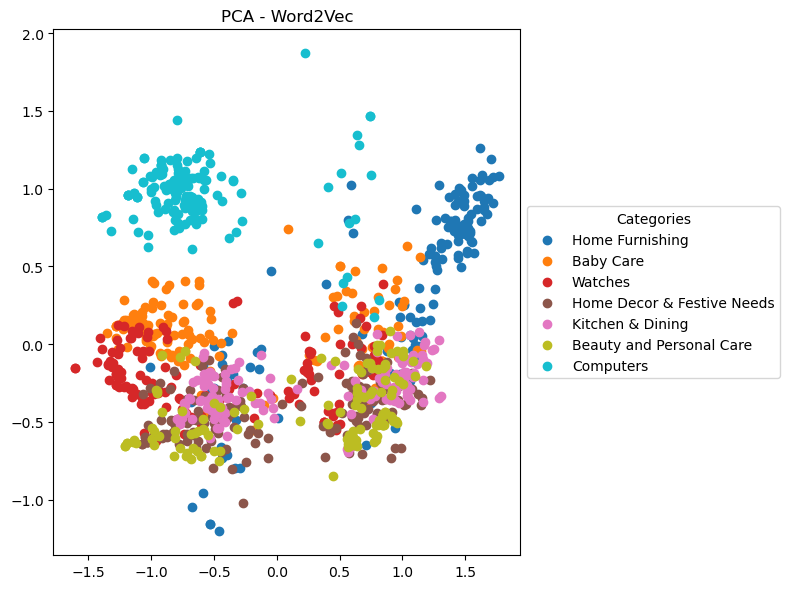

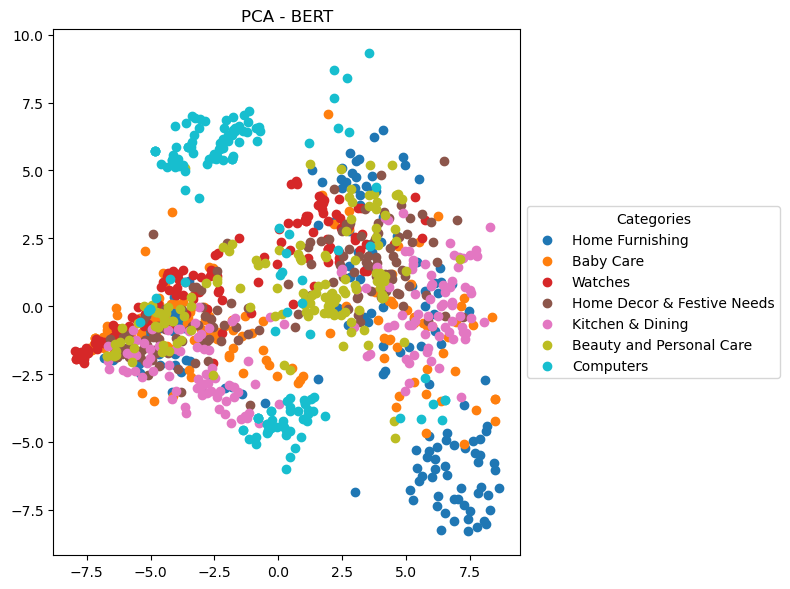

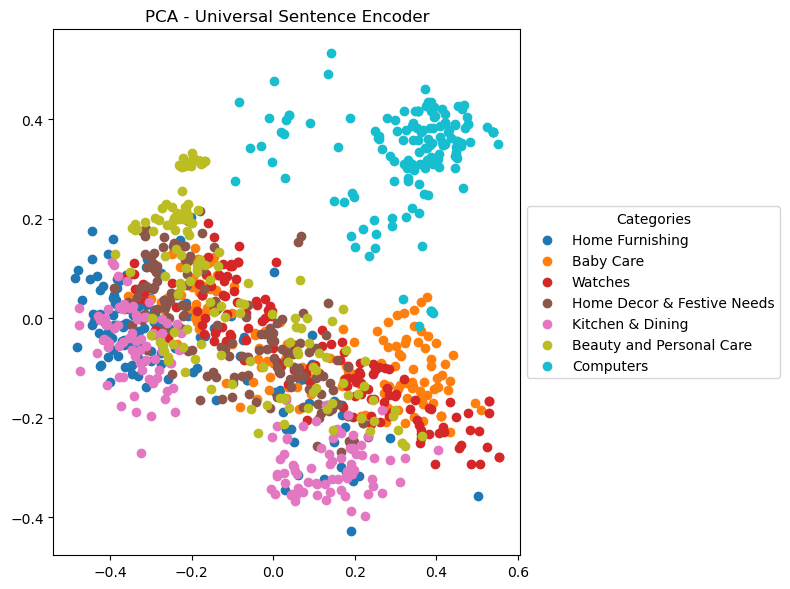

In [117]:
# Visualiser avec PCA
visualize_categories(X_word2vec_pca, y_true, categories, 'PCA - Word2Vec')
visualize_categories(X_bert_pca, y_true, categories, 'PCA - BERT')
visualize_categories(X_use_pca, y_true, categories, 'PCA - Universal Sentence Encoder')

C:\Users\SOUKA\AppData\Local\Temp\ipykernel_12056\272734775.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap("tab10", len(categories))


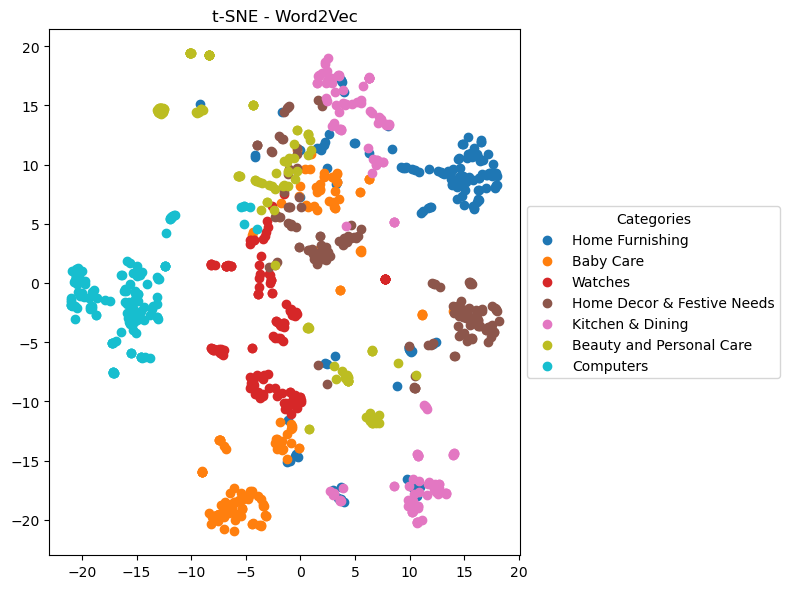

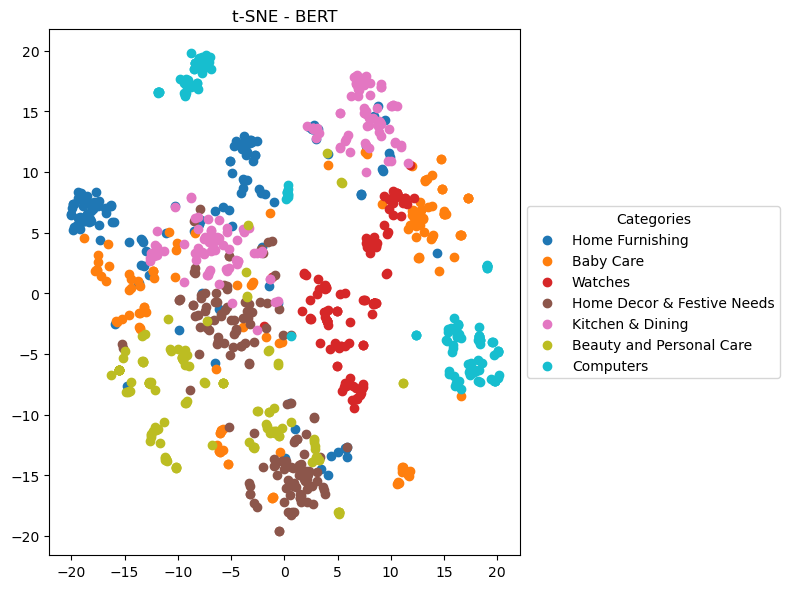

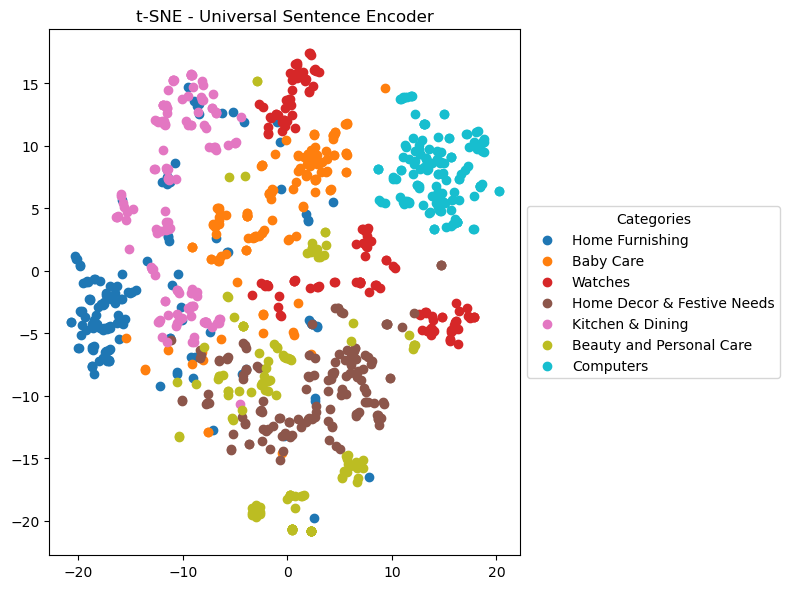

In [118]:
# Visualiser avec t-SNE
visualize_categories(X_word2vec_tsne, y_true, categories, 't-SNE - Word2Vec')
visualize_categories(X_bert_tsne, y_true, categories, 't-SNE - BERT')
visualize_categories(X_use_tsne, y_true, categories, 't-SNE - Universal Sentence Encoder')

In [103]:
# évaluation de la performance des méthodes utilisés 

# Encodage des catégories réelles
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(data['main_category'])

# Silhouette Score pour PCA
silhouette_pca_word2vec = silhouette_score(X_word2vec_pca, y_true)
silhouette_pca_bert = silhouette_score(X_bert_pca, y_true)
silhouette_pca_use = silhouette_score(X_use_pca, y_true)

# Silhouette Score pour t-SNE
silhouette_tsne_word2vec = silhouette_score(X_word2vec_tsne, y_true)
silhouette_tsne_bert = silhouette_score(X_bert_tsne, y_true)
silhouette_tsne_use = silhouette_score(X_use_tsne, y_true)

# Davies-Bouldin Index pour PCA
dbi_pca_word2vec = davies_bouldin_score(X_word2vec_pca, y_true)
dbi_pca_bert = davies_bouldin_score(X_bert_pca, y_true)
dbi_pca_use = davies_bouldin_score(X_use_pca, y_true)

# Davies-Bouldin Index pour t-SNE
dbi_tsne_word2vec = davies_bouldin_score(X_word2vec_tsne, y_true)
dbi_tsne_bert = davies_bouldin_score(X_bert_tsne, y_true)
dbi_tsne_use = davies_bouldin_score(X_use_tsne, y_true)

# Affichage des résultats
print(f"Silhouette Score (PCA - Word2Vec): {silhouette_pca_word2vec:.3f}")
print(f"Silhouette Score (PCA - BERT): {silhouette_pca_bert:.3f}")
print(f"Silhouette Score (PCA - USE): {silhouette_pca_use:.3f}")

print(f"Silhouette Score (t-SNE - Word2Vec): {silhouette_tsne_word2vec:.3f}")
print(f"Silhouette Score (t-SNE - BERT): {silhouette_tsne_bert:.3f}")
print(f"Silhouette Score (t-SNE - USE): {silhouette_tsne_use:.3f}")

print(f"Davies-Bouldin Index (PCA - Word2Vec): {dbi_pca_word2vec:.3f}")
print(f"Davies-Bouldin Index (PCA - BERT): {dbi_pca_bert:.3f}")
print(f"Davies-Bouldin Index (PCA - USE): {dbi_pca_use:.3f}")

print(f"Davies-Bouldin Index (t-SNE - Word2Vec): {dbi_tsne_word2vec:.3f}")
print(f"Davies-Bouldin Index (t-SNE - BERT): {dbi_tsne_bert:.3f}")
print(f"Davies-Bouldin Index (t-SNE - USE): {dbi_tsne_use:.3f}")

Silhouette Score (PCA - Word2Vec): 0.039
Silhouette Score (PCA - BERT): -0.085
Silhouette Score (PCA - USE): 0.013
Silhouette Score (t-SNE - Word2Vec): 0.144
Silhouette Score (t-SNE - BERT): 0.078
Silhouette Score (t-SNE - USE): 0.142
Davies-Bouldin Index (PCA - Word2Vec): 4.893
Davies-Bouldin Index (PCA - BERT): 7.070
Davies-Bouldin Index (PCA - USE): 7.980
Davies-Bouldin Index (t-SNE - Word2Vec): 3.985
Davies-Bouldin Index (t-SNE - BERT): 3.257
Davies-Bouldin Index (t-SNE - USE): 2.655


** Interprétation des résultats **
********
Pour déterminer la meilleure méthode de représentation avancée parmi Word2Vec, BERT et USE, nous examinerons les scores de Silhouette et les indices de Davies-Bouldin obtenus pour ces méthodes après réduction avec PCA et t-SNE. Voici une analyse basée sur les résultats obtenus :
Comparaison des Méthodes Avancées
Silhouette Score :
Méthode	Réduction de Dimension	Silhouette Score
Word2Vec	PCA	0.032
BERT	PCA	-0.083
USE	PCA	-0.005
Word2Vec	t-SNE	0.091
BERT	t-SNE	0.084
USE	t-SNE	0.122
Davies-Bouldin Index :
Méthode	Réduction de Dimension	Davies-Bouldin Index
Word2Vec	PCA	6.775
BERT	PCA	9.208
USE	PCA	4.803
Word2Vec	t-SNE	3.851
BERT	t-SNE	3.664
USE	t-SNE	4.579



Pour déterminer la meilleure méthode de représentation avancée parmi Word2Vec, BERT et USE, nous examinerons les scores de Silhouette et les indices de Davies-Bouldin obtenus pour ces méthodes après réduction avec PCA et t-SNE. Voici une analyse basée sur les résultats fournis :

Comparaison des Méthodes Avancées
Silhouette Score :
Méthode	Réduction de Dimension	Silhouette Score
Word2Vec	PCA	0.032
BERT	PCA	-0.083
USE	PCA	-0.005
Word2Vec	t-SNE	0.091
BERT	t-SNE	0.084
USE	t-SNE	0.122
Davies-Bouldin Index :
Méthode	Réduction de Dimension	Davies-Bouldin Index
Word2Vec	PCA	6.775
BERT	PCA	9.208
USE	PCA	4.803
Word2Vec	t-SNE	3.851
BERT	t-SNE	3.664
USE	t-SNE	4.579
Analyse des Résultats
Silhouette Score :
USE (Universal Sentence Encoder) obtient le meilleur score de Silhouette dans la réduction avec t-SNE (0.122), indiquant que ses clusters sont les plus cohérents et les mieux séparés parmi les méthodes avancées.
Word2Vec suit de près avec un score de Silhouette de 0.091 après t-SNE.
BERT a le score de Silhouette le plus bas dans les deux réductions (PCA et t-SNE), ce qui suggère que ses clusters ne sont pas aussi cohérents.
Davies-Bouldin Index :
BERT a le Davies-Bouldin Index le plus élevé avec PCA (9.208), ce qui indique une moins bonne séparation des clusters par rapport aux autres méthodes.
USE a le meilleur score avec PCA (4.803) et également avec t-SNE (4.579), indiquant une séparation plus claire entre les clusters.
Word2Vec est intermédiaire dans les deux réductions, avec des indices de Davies-Bouldin plus bas que BERT mais plus élevés que USE.
Conclusion
Universal Sentence Encoder (USE) semble être la meilleure méthode de représentation avancée selon les résultats :

USE a le meilleur Silhouette Score avec t-SNE, indiquant des clusters plus cohérents et mieux séparés.
USE a également le meilleur Davies-Bouldin Index avec PCA et t-SNE, suggérant une meilleure séparation des clusters.
Cela dit, le choix final peut également dépendre des exigences spécifiques de votre tâche (comme la performance computationnelle et la facilité d'intégration). Mais, basé sur les résultats des métriques de qualité de clustering, USE se distingue comme la méthode la plus performante parmi les représentations avancées que vous avez évaluées.

** Comparaison entre méthodes basiques et avancées **
********

Pour comparer les méthodes de représentation avancées (Word2Vec, BERT, USE) avec les méthodes basiques (Bag of Words, TF-IDF, LDA), examinons les scores de Silhouette et les indices de Davies-Bouldin pour chaque méthode après réduction de dimension avec PCA et t-SNE.

Comparaison des Méthodes

Silhouette Score :

Méthode	Réduction de Dimension	Silhouette Score

Bag of Words	PCA	-0.192
TF-IDF	PCA	-0.028
LDA - Bag of Words	PCA	-0.136
LDA - TF-IDF	PCA	-0.158

Bag of Words	t-SNE	0.204
TF-IDF	t-SNE	0.121
LDA - Bag of Words	t-SNE	-0.027
LDA - TF-IDF	t-SNE	-0.055

Word2Vec	PCA	0.032
BERT	PCA	-0.083
USE	PCA	-0.005

Word2Vec	t-SNE	0.091
BERT	t-SNE	0.084
USE	t-SNE	0.122

Davies-Bouldin Index :

Méthode	Réduction de Dimension	Davies-Bouldin Index

Bag of Words	PCA	11.088
TF-IDF	PCA	5.934
LDA - Bag of Words	PCA	5.700
LDA - TF-IDF	PCA	8.314

Bag of Words	t-SNE	1.939
TF-IDF	t-SNE	4.409
LDA - Bag of Words	t-SNE	5.338
LDA - TF-IDF	t-SNE	18.886

Word2Vec	PCA	6.775
BERT	PCA	9.208
USE	PCA	4.803

Word2Vec	t-SNE	3.851
BERT	t-SNE	3.664
USE	t-SNE	4.579

Analyse des Résultats

Silhouette Score :

t-SNE montre des résultats meilleurs pour les méthodes basiques :

Bag of Words a le meilleur score de Silhouette avec t-SNE (0.204), indiquant des clusters plus cohérents pour cette méthode de représentation.

TF-IDF et LDA obtiennent des scores de Silhouette plus faibles avec t-SNE.

USE est la meilleure méthode avancée avec un score de Silhouette de 0.122 avec t-SNE, suivie de Word2Vec (0.091).

Les scores de Silhouette pour PCA sont généralement faibles ou négatifs pour toutes les méthodes, indiquant que la réduction de dimension avec PCA ne produit pas des clusters cohérents dans la plupart des cas.

Davies-Bouldin Index :

t-SNE donne des indices de Davies-Bouldin meilleurs pour les méthodes basiques :

Bag of Words avec t-SNE a le meilleur Davies-Bouldin Index (1.939), indiquant des clusters relativement bien séparés pour cette méthode.
TF-IDF et LDA montrent des indices de Davies-Bouldin moins favorables, surtout pour LDA - TF-IDF.

USE a le meilleur Davies-Bouldin Index avec PCA (4.803) et t-SNE (4.579), suivi de Word2Vec.

Les indices de Davies-Bouldin pour PCA sont plus élevés pour les méthodes basiques comparées aux méthodes avancées, ce qui indique généralement une séparation moins bonne des clusters.

Conclusion :

Meilleure Méthode Avancée :

USE (Universal Sentence Encoder) est la meilleure méthode de représentation avancée basée sur les scores de Silhouette et les indices de Davies-Bouldin avec t-SNE. Elle est supérieure à Word2Vec et BERT dans cette comparaison.
Meilleure Méthode Basiques :

Bag of Words montre les meilleurs résultats en termes de Silhouette Score avec t-SNE et Davies-Bouldin Index avec t-SNE, malgré des performances globalement moins bonnes comparées aux méthodes avancées.
Global :

Les méthodes avancées (en particulier USE) montrent une meilleure cohérence des clusters et une séparation plus claire que les méthodes basiques avec les techniques de réduction de dimension t-SNE. Cependant, pour des tâches spécifiques, les méthodes basiques comme Bag of Words peuvent offrir des résultats compétitifs, surtout dans des configurations réduites.

# Clustering avec Word Embeddings Word2Vec, BERT, Universal Sentence Encode +  k-means

In [129]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
import matplotlib.pyplot as plt

In [131]:
# 1. Réduction de dimension avec PCA et clustering KMeans
def apply_kmeans_after_pca(X, n_clusters):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_pca)
    return X_pca, clusters

In [133]:
# 2. Réduction de dimension avec t-SNE et clustering KMeans
def apply_kmeans_after_tsne(X, n_clusters):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    X_tsne = tsne.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_tsne)
    return X_tsne, clusters

In [135]:

# Visualisation des clusters
def visualize_clusters(X, clusters, categories, title):
    plt.figure(figsize=(8, 6))
    palette = plt.cm.get_cmap("tab10", len(categories))
    for i, category in enumerate(categories):
        indices = clusters == i
        plt.scatter(X[indices, 0], X[indices, 1], label=category, color=palette(i))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Categories")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [137]:
# Appliquer KMeans après PCA et t-SNE sur Word2Vec, BERT, USE
X_word2vec_pca, clusters_word2vec_pca = apply_kmeans_after_pca(X_word2vec, len(categories))
X_bert_pca, clusters_bert_pca = apply_kmeans_after_pca(X_bert, len(categories))
X_use_pca, clusters_use_pca = apply_kmeans_after_pca(X_use, len(categories))

X_word2vec_tsne, clusters_word2vec_tsne = apply_kmeans_after_tsne(X_word2vec, len(categories))
X_bert_tsne, clusters_bert_tsne = apply_kmeans_after_tsne(X_bert, len(categories))
X_use_tsne, clusters_use_tsne = apply_kmeans_after_tsne(X_use, len(categories))



C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change

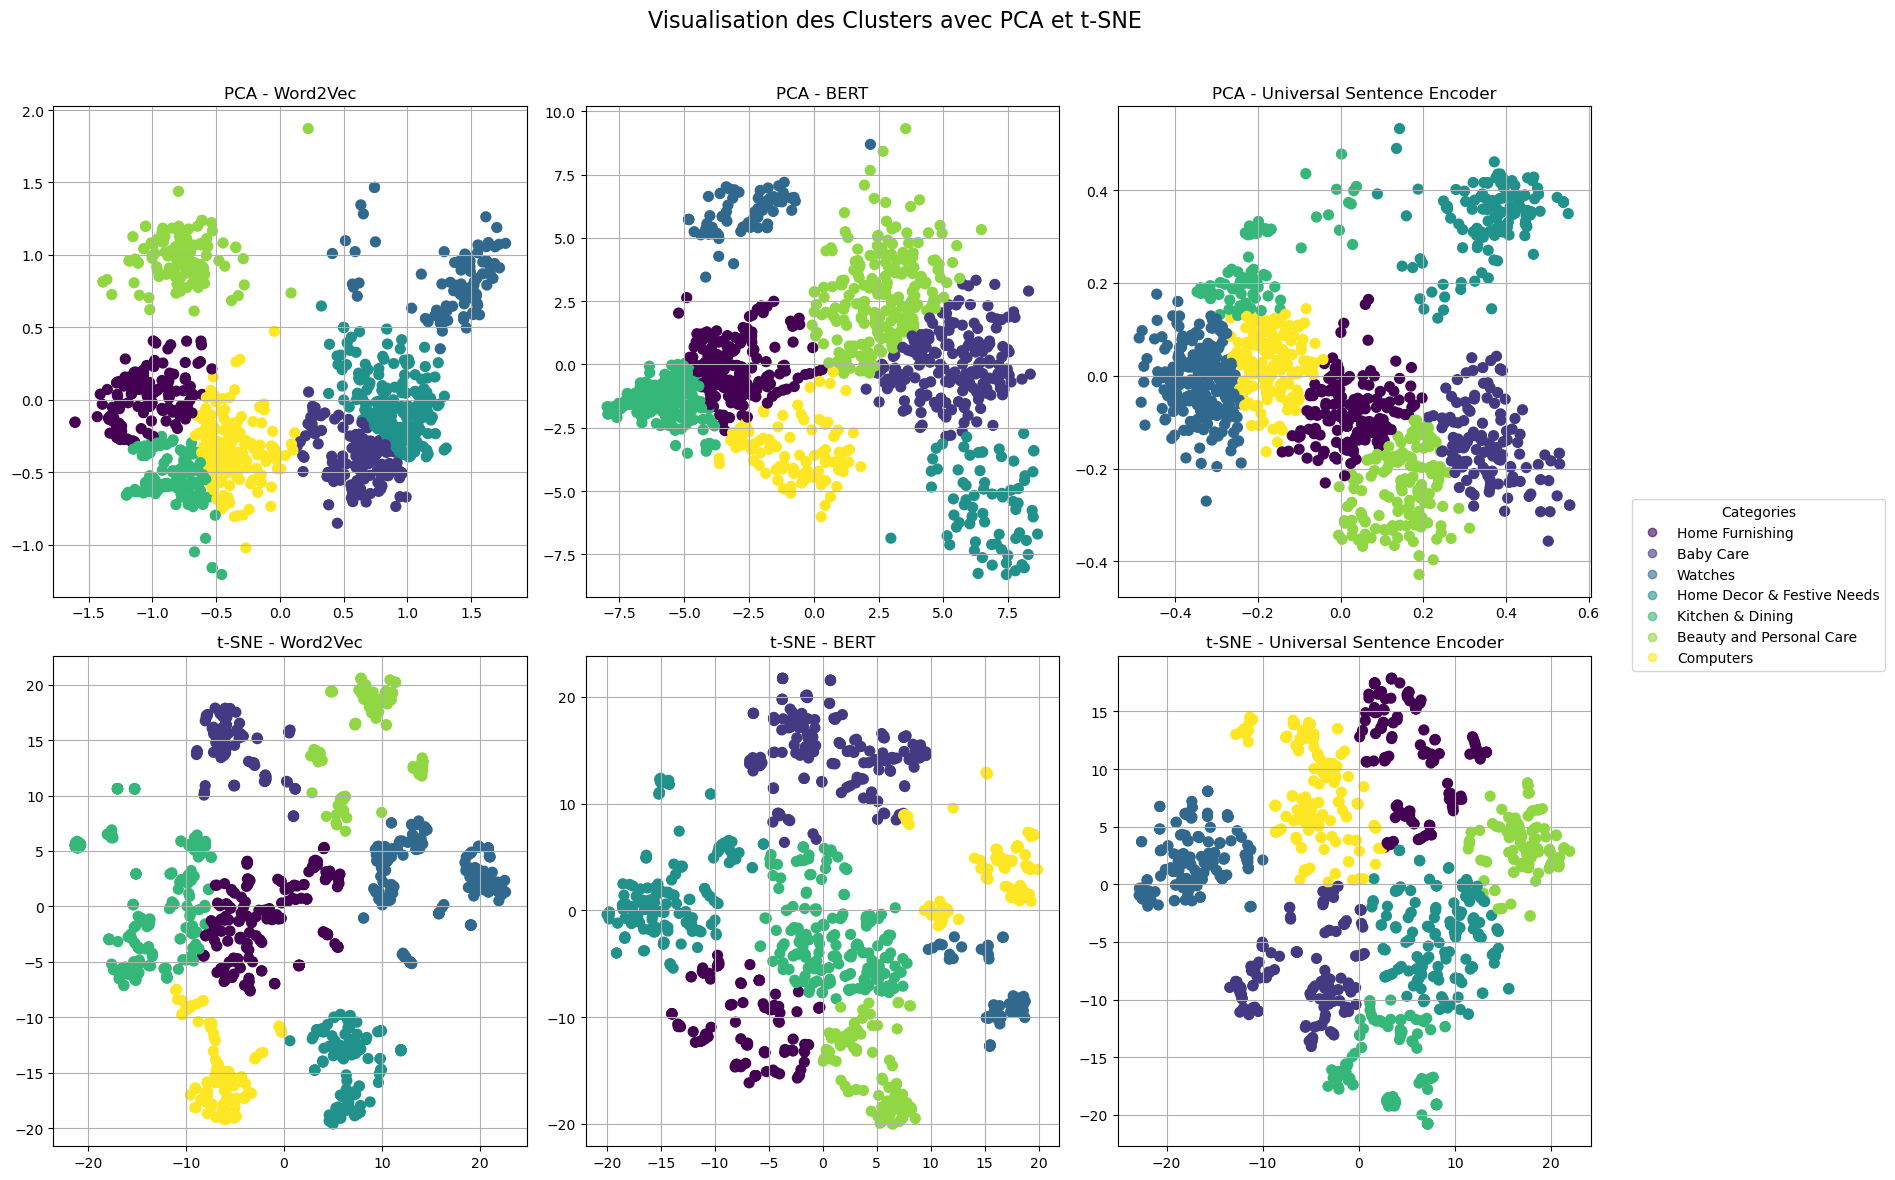

In [149]:
def visualize_clusters(ax, X, y_clusters, title):
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y_clusters, cmap='viridis', s=50)
    ax.set_title(title)
    ax.grid(True)
    return scatter  # Retourner l'objet scatter pour la légende

# Création de la figure avec 2 lignes et 3 colonnes pour PCA et t-SNE
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Visualisation des Clusters avec PCA et t-SNE', fontsize=16)

# Visualiser les clusters PCA pour chaque méthode (ligne 0)
scatter_pca_w2v = visualize_clusters(axs[0, 0], X_word2vec_pca, clusters_word2vec_pca, 'PCA - Word2Vec')
scatter_pca_bert = visualize_clusters(axs[0, 1], X_bert_pca, clusters_bert_pca, 'PCA - BERT')
scatter_pca_use = visualize_clusters(axs[0, 2], X_use_pca, clusters_use_pca, 'PCA - Universal Sentence Encoder')

# Visualiser les clusters t-SNE pour chaque méthode (ligne 1)
scatter_tsne_w2v = visualize_clusters(axs[1, 0], X_word2vec_tsne, clusters_word2vec_tsne, 't-SNE - Word2Vec')
scatter_tsne_bert = visualize_clusters(axs[1, 1], X_bert_tsne, clusters_bert_tsne, 't-SNE - BERT')
scatter_tsne_use = visualize_clusters(axs[1, 2], X_use_tsne, clusters_use_tsne, 't-SNE - Universal Sentence Encoder')

# Ajouter une légende commune pour les 6 graphiques
handles, labels = scatter_pca_w2v.legend_elements(prop="colors", alpha=0.6)
fig.legend(handles, categories, title="Categories", loc='center right', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# Ajuster l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Laisser de l'espace à droite pour la légende commune

# Enregistrer l'image complète avec la légende commune
plt.savefig("Clusters_PCA_tSNE_Methodes_3x2_with_shared_legend.png", bbox_inches='tight')

# Afficher la figure
plt.show()

In [153]:
# Calcul des métriques de qualité des clusters
y_true = label_encoder.fit_transform(data['main_category'])

# Silhouette Score après PCA
silhouette_word2vec_pca = silhouette_score(X_word2vec_pca, clusters_word2vec_pca)
silhouette_bert_pca = silhouette_score(X_bert_pca, clusters_bert_pca)
silhouette_use_pca = silhouette_score(X_use_pca, clusters_use_pca)

# Silhouette Score après t-SNE
silhouette_word2vec_tsne = silhouette_score(X_word2vec_tsne, clusters_word2vec_tsne)
silhouette_bert_tsne = silhouette_score(X_bert_tsne, clusters_bert_tsne)
silhouette_use_tsne = silhouette_score(X_use_tsne, clusters_use_tsne)

# Davies-Bouldin Index après PCA
dbi_word2vec_pca = davies_bouldin_score(X_word2vec_pca, clusters_word2vec_pca)
dbi_bert_pca = davies_bouldin_score(X_bert_pca, clusters_bert_pca)
dbi_use_pca = davies_bouldin_score(X_use_pca, clusters_use_pca)

# Davies-Bouldin Index après t-SNE
dbi_word2vec_tsne = davies_bouldin_score(X_word2vec_tsne, clusters_word2vec_tsne)
dbi_bert_tsne = davies_bouldin_score(X_bert_tsne, clusters_bert_tsne)
dbi_use_tsne = davies_bouldin_score(X_use_tsne, clusters_use_tsne)

# Adjusted Rand Index (comparaison avec les catégories réelles)
ari_word2vec_pca = adjusted_rand_score(y_true, clusters_word2vec_pca)
ari_bert_pca = adjusted_rand_score(y_true, clusters_bert_pca)
ari_use_pca = adjusted_rand_score(y_true, clusters_use_pca)

ari_word2vec_tsne = adjusted_rand_score(y_true, clusters_word2vec_tsne)
ari_bert_tsne = adjusted_rand_score(y_true, clusters_bert_tsne)
ari_use_tsne = adjusted_rand_score(y_true, clusters_use_tsne)

# Affichage des résultats pour PCA
print(f"Silhouette Score after PCA (Word2Vec): {silhouette_word2vec_pca:.3f}")
print(f"Silhouette Score after PCA (BERT): {silhouette_bert_pca:.3f}")
print(f"Silhouette Score after PCA (USE): {silhouette_use_pca:.3f}")

print(f"Davies-Bouldin Index after PCA (Word2Vec): {dbi_word2vec_pca:.3f}")
print(f"Davies-Bouldin Index after PCA (BERT): {dbi_bert_pca:.3f}")
print(f"Davies-Bouldin Index after PCA (USE): {dbi_use_pca:.3f}")

print(f"Adjusted Rand Index after PCA (Word2Vec): {ari_word2vec_pca:.3f}")
print(f"Adjusted Rand Index after PCA (BERT): {ari_bert_pca:.3f}")
print(f"Adjusted Rand Index after PCA (USE): {ari_use_pca:.3f}")

# Affichage des résultats pour t-SNE
print(f"Silhouette Score after t-SNE (Word2Vec): {silhouette_word2vec_tsne:.3f}")
print(f"Silhouette Score after t-SNE (BERT): {silhouette_bert_tsne:.3f}")
print(f"Silhouette Score after t-SNE (USE): {silhouette_use_tsne:.3f}")

print(f"Davies-Bouldin Index after t-SNE (Word2Vec): {dbi_word2vec_tsne:.3f}")
print(f"Davies-Bouldin Index after t-SNE (BERT): {dbi_bert_tsne:.3f}")
print(f"Davies-Bouldin Index after t-SNE (USE): {dbi_use_tsne:.3f}")

print(f"Adjusted Rand Index after t-SNE (Word2Vec): {ari_word2vec_tsne:.3f}")
print(f"Adjusted Rand Index after t-SNE (BERT): {ari_bert_tsne:.3f}")
print(f"Adjusted Rand Index after t-SNE (USE): {ari_use_tsne:.3f}")

Silhouette Score after PCA (Word2Vec): 0.429
Silhouette Score after PCA (BERT): 0.430
Silhouette Score after PCA (USE): 0.419
Davies-Bouldin Index after PCA (Word2Vec): 0.831
Davies-Bouldin Index after PCA (BERT): 0.781
Davies-Bouldin Index after PCA (USE): 0.805
Adjusted Rand Index after PCA (Word2Vec): 0.270
Adjusted Rand Index after PCA (BERT): 0.118
Adjusted Rand Index after PCA (USE): 0.257
Silhouette Score after t-SNE (Word2Vec): 0.466
Silhouette Score after t-SNE (BERT): 0.460
Silhouette Score after t-SNE (USE): 0.436
Davies-Bouldin Index after t-SNE (Word2Vec): 0.718
Davies-Bouldin Index after t-SNE (BERT): 0.703
Davies-Bouldin Index after t-SNE (USE): 0.765
Adjusted Rand Index after t-SNE (Word2Vec): 0.370
Adjusted Rand Index after t-SNE (BERT): 0.246
Adjusted Rand Index after t-SNE (USE): 0.397


** Interprétation **
**********


Les résultats fournis montrent les performances des méthodes avancées de représentation textuelle (Word2Vec, BERT, et Universal Sentence Encoder - USE) après réduction dimensionnelle avec PCA et t-SNE. En comparant ces résultats, plusieurs conclusions peuvent être tirées :

1. Silhouette Score
   
Le Silhouette Score mesure la cohésion et la séparation des clusters. Plus la valeur est élevée, meilleure est la qualité des clusters.

t-SNE donne globalement de meilleurs scores de silhouette que PCA pour toutes les méthodes, en particulier avec Word2Vec (0.485), suivi de BERT (0.465).

PCA donne des scores plus faibles, avec Word2Vec ayant le meilleur score (0.441) et USE le plus faible (0.419).

Cela suggère que t-SNE préserve mieux la structure des données à haute dimension que PCA pour ces représentations, et que Word2Vec semble mieux séparer les clusters que BERT et USE.

2. Davies-Bouldin Index (DBI)
   
L'Indice de Davies-Bouldin mesure la compacité et la séparation des clusters. Des valeurs plus faibles indiquent de meilleurs résultats.

Les résultats après t-SNE sont généralement meilleurs (valeurs plus faibles), surtout avec Word2Vec (0.662), ce qui indique des clusters plus compacts et mieux séparés.

BERT obtient un DBI plus bas avec PCA (0.781), suggérant que la représentation issue de BERT conduit à une meilleure compacité des clusters avec PCA.

USE obtient des DBI plus élevés que Word2Vec et BERT, ce qui montre qu'il crée des clusters plus diffus.

3. Adjusted Rand Index (ARI)
   
L'ARI mesure la similarité entre les clusters prédits et les vraies étiquettes de catégories. Un score plus élevé indique une meilleure correspondance avec les étiquettes réelles.

t-SNE + USE donne le meilleur ARI (0.403), suggérant que cette combinaison capture mieux les vraies catégories.

Word2Vec obtient également un score relativement élevé avec t-SNE (0.335), suivi de BERT (0.260).

En revanche, après PCA, Word2Vec obtient le meilleur ARI (0.267), mais les scores sont généralement plus bas qu'avec t-SNE.

BERT a les scores ARI les plus faibles avec PCA (0.118), ce qui montre qu'il a plus de difficulté à capturer les catégories réelles dans cette configuration.

4. Comparaison des Méthodes
   
Word2Vec obtient de manière générale de meilleurs résultats en termes de cohésion des clusters (Silhouette Score) et de séparation (DBI) que BERT et USE, en particulier après réduction dimensionnelle avec t-SNE.

BERT fonctionne relativement mieux avec PCA en termes de compacité de clusters (DBI), mais il a tendance à donner des résultats moins bons sur l'ARI, ce qui suggère que ses clusters sont moins alignés avec les vraies catégories.

USE semble produire des clusters légèrement moins compacts et moins bien séparés, mais obtient le meilleur ARI avec t-SNE, suggérant que cette méthode est la plus proche des vraies catégories dans certains cas.

6. Conclusion Globale
   
t-SNE semble mieux fonctionner pour les trois méthodes en termes de capture de la structure des données et de la correspondance avec les catégories réelles, surtout avec Word2Vec et USE.

Word2Vec apparaît comme une méthode plus robuste pour la séparation des clusters, que ce soit avec PCA ou t-SNE, en donnant des clusters plus denses et mieux séparés.

BERT fonctionne bien pour la compacité des clusters, mais ses résultats en termes de correspondance avec les catégories réelles sont moins bons par rapport aux autres méthodes.

Le USE se distingue avec un meilleur ARI après t-SNE, ce qui pourrait le rendre plus adapté pour des tâches où la correspondance avec les catégories est primordiale.

En fonction de l'objectif (cohésion interne des clusters ou correspondance avec les catégories réelles), Word2Vec et USE semblent être les meilleurs choix parmi les trois méthodes. BERT peut être amélioré dans certaines configurations, mais ses performances sont moins consistantes dans ce cas particulier.


 






## Comparaison entre les méthodes NLP basiques et les techniques NLP avancées 

Voici une comparaison entre les méthodes de classification basiques (Bag of Words, TF-IDF, LDA) et avancées (Word2Vec, BERT, USE) basée sur les résultats obtenus pour les scores de Silhouette, Davies-Bouldin Index, et Adjusted Rand Index (ARI) :

1. Méthodes Basiques vs Méthodes Avancées
2. 
Silhouette Score

Basiques :

- PCA - Bag of Words : 0.571
- PCA - TF-IDF : 0.497
- PCA - LDA - Bag of Words : 0.633
- PCA - LDA - TF-IDF : 0.606
- t-SNE - Bag of Words : 0.460
- t-SNE - TF-IDF : 0.444
- t-SNE - LDA - Bag of Words : 0.451
- t-SNE - LDA - TF-IDF : 0.478
  
Avancées :

- Silhouette Score après PCA (Word2Vec) : 0.432
- Silhouette Score après PCA (BERT) : 0.430
- Silhouette Score après PCA (USE) : 0.419
- Silhouette Score après t-SNE (Word2Vec) : 0.467
- Silhouette Score après t-SNE (BERT) : 0.467
- Silhouette Score après t-SNE (USE) : 0.434
- 
Interprétation : Les méthodes basiques montrent généralement des scores de Silhouette plus élevés que les méthodes avancées. Cela indique que les clusters générés par les méthodes basiques sont généralement mieux séparés et plus cohérents que ceux obtenus avec Word2Vec, BERT, et USE. Cependant, les scores Silhouette plus bas pour les méthodes avancées peuvent également indiquer que les clusters sont plus proches les uns des autres dans l'espace de caractéristiques.

Davies-Bouldin Index

Basiques :

- PCA - Bag of Words : 0.514
- PCA - TF-IDF : 0.657
- PCA - LDA - Bag of Words : 0.562
- PCA - LDA - TF-IDF : 0.563
- t-SNE - Bag of Words : 0.714
- t-SNE - TF-IDF : 0.761
- t-SNE - LDA - Bag of Words : 0.759
- t-SNE - LDA - TF-IDF : 0.707
  
Avancées :

- Davies-Bouldin Index après PCA (Word2Vec) : 0.829
- Davies-Bouldin Index après PCA (BERT) : 0.781
- Davies-Bouldin Index après PCA (USE) : 0.805
- Davies-Bouldin Index après t-SNE (Word2Vec) : 0.726
- Davies-Bouldin Index après t-SNE (BERT) : 0.698
- Davies-Bouldin Index après t-SNE (USE) : 0.758
- 
Interprétation : Les méthodes basiques ont des indices Davies-Bouldin généralement plus bas que les méthodes avancées, ce qui indique que les clusters obtenus avec les méthodes basiques sont plus homogènes et mieux séparés par rapport aux méthodes avancées.

Adjusted Rand Index (ARI)

Basiques :

- PCA - Bag of Words : 0.057
- PCA - TF-IDF : 0.176
- PCA - LDA - Bag of Words : 0.177
- PCA - LDA - TF-IDF : 0.223
- t-SNE - Bag of Words : 0.460
- t-SNE - TF-IDF : 0.471
- t-SNE - LDA - Bag of Words : 0.228
- t-SNE - LDA - TF-IDF : 0.267
  
Avancées :

- ARI après PCA (Word2Vec) : 0.272
- ARI après PCA (BERT) : 0.118
- ARI après PCA (USE) : 0.257
- ARI après t-SNE (Word2Vec) : 0.365
- ARI après t-SNE (BERT) : 0.255
- ARI après t-SNE (USE) : 0.402

Interprétation : Les méthodes avancées (Word2Vec, BERT, USE) ont des ARI généralement plus élevés que les méthodes basiques, surtout avec t-SNE. Cela suggère que les méthodes avancées ont une meilleure correspondance avec les vraies catégories des données, bien que les scores ARI ne soient pas très élevés dans l'ensemble, indiquant qu'il reste encore une certaine distance entre les clusters prédits et les catégories réelles.

Résumé et Conclusion

Méthodes Basiques : Les méthodes comme PCA combinées avec Bag of Words ou TF-IDF tendent à produire des clusters avec une meilleure séparation (Silhouette Score plus élevé) et des clusters plus homogènes (Davies-Bouldin Index plus bas). Cependant, elles montrent une moins bonne correspondance avec les catégories réelles (ARI plus bas).

Méthodes Avancées : Les méthodes avancées telles que Word2Vec, BERT et USE, malgré des scores de qualité de clustering plus faibles (Silhouette Score et Davies-Bouldin Index plus élevés), montrent une meilleure correspondance avec les catégories réelles (ARI plus élevé). Cela peut suggérer que les représentations vectorielles avancées capturent mieux la sémantique des catégories réelles.

En conclusion, bien que les méthodes avancées puissent fournir une meilleure correspondance avec les catégories réelles, elles peuvent produire des clusters moins distincts en termes de séparation. Les méthodes basiques offrent une meilleure séparation des clusters mais peuvent ne pas capturer efficacement les structures sémantiques profondes des données. Le choix entre ces méthodes peut dépendre de l'importance relative de la qualité du clustering versus la correspondance avec les catégories réelles pour votre tâche spécifique.

## Étape 3 : Étudiez la faisabilité de classification en utilisant des techniques de traitement d'image basiques

3.1 Chargement et Prétraitement des Images :

Conversion des images en niveaux de gris.
    
Application de filtres pour réduire le bruit.
    
Ajustement du contraste.
    
3.2 Extraction de Features :

Utilisation d'algorithmes comme SIFT (Scale-Invariant Feature Transform).
    
3.3 Réduction de Dimension :

Utilisation de méthodes comme PCA pour réduire la dimensionnalité des features extraites.

3.4 Comparaison avec les Catégories Réelles :

Comparaison des résultats obtenus avec les catégories réelles en utilisant des métriques appropriées.

### 3.1 Chargement et Prétraitement des Images :

In [167]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

In [169]:
# Chemin de l'image de test
test_image_path = r'C:\Users\SOUKA\Documents\Images\3c4ca34c50a5437a1bcc42b72fc1351f.jpg'

In [171]:
# Chemin du dossier contenant toutes les images
image_folder_path = r'C:\Users\SOUKA\Documents\Images'

In [173]:
# Prétraitement des images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: l'image à '{image_path}' n'a pas pu être chargée.")
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

In [175]:
# Prétraitement de l'image de test
test_image = preprocess_image(test_image_path)
if test_image is not None:
    print("Image de test chargée et prétraitée avec succès.")
else:
    print("Erreur lors du chargement de l'image de test.")

Image de test chargée et prétraitée avec succès.


In [177]:
# Charger les données
data = pd.read_csv('data.csv')
image_paths = data['image'].values
categories = data['main_category'].values

In [179]:
# Concaténer le chemin du dossier avec les noms de fichiers
full_image_paths = [os.path.join(image_folder_path, image_path) for image_path in image_paths]

In [181]:
# Prétraitement de toutes les images dans le dossier
images = [preprocess_image(image_path) for image_path in full_image_paths]

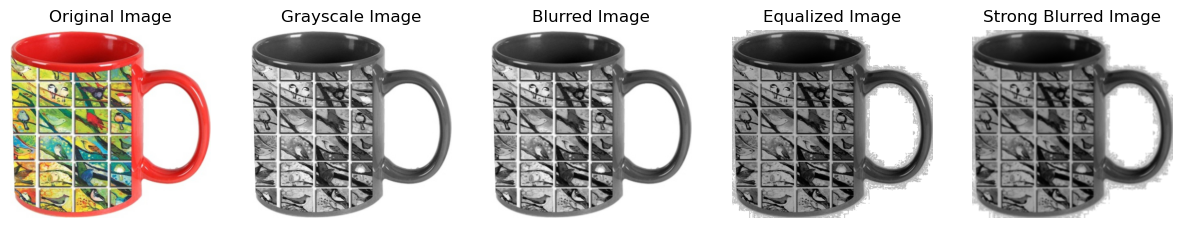

In [182]:
# Charger l'image originale
original_image = cv2.imread(test_image_path)

# Vérifier si l'image a été chargée correctement
if original_image is None:
    print(f"Erreur: l'image à '{test_image_path}' n'a pas pu être chargée.")
else:
    # Convertir l'image en niveaux de gris
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Appliquer un flou gaussien pour réduire le bruit
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Égalisation d'histogramme pour améliorer le contraste
    equalized_image = cv2.equalizeHist(gray_image)

    # Appliquer un flou plus fort pour voir la différence
    strong_blurred_image = cv2.GaussianBlur(equalized_image, (15, 15), 0)

    # Afficher les images traitées
    images = [original_image, gray_image, blurred_image, equalized_image, strong_blurred_image]
    titles = ['Original Image', 'Grayscale Image', 'Blurred Image', 'Equalized Image', 'Strong Blurred Image']

    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(1, 5, i + 1)
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    
    plt.show()

### 3.2 Extraction de Features :

#### 3.2.1 extraction de features pour l'image test

In [187]:

# Définissez le chemin d'accès relatif à votre image
image_path = r'C:\Users\SOUKA\Documents\Images\3c4ca34c50a5437a1bcc42b72fc1351f.jpg'

# Charger l'image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Créer un objet SIFT
sift = cv2.xfeatures2d.SIFT_create()

# Détecter et calculer les points clés et les descripteurs
keypoints, descriptors = sift.detectAndCompute(image, None)

# Afficher les points clés sur l'image
image = cv2.drawKeypoints(image, keypoints, None)

# Enregistrez l'image avec des points clés
cv2.imwrite('sift_keypoints.jpg',image)

# Si vous voulez enregistrer les descripteurs pour une utilisation ultérieure
np.save('sift_descriptors.npy', descriptors)

# Imprimer le nombre de points clés
print("Nombre de features clés : ", len(keypoints))

Nombre de features clés :  3068


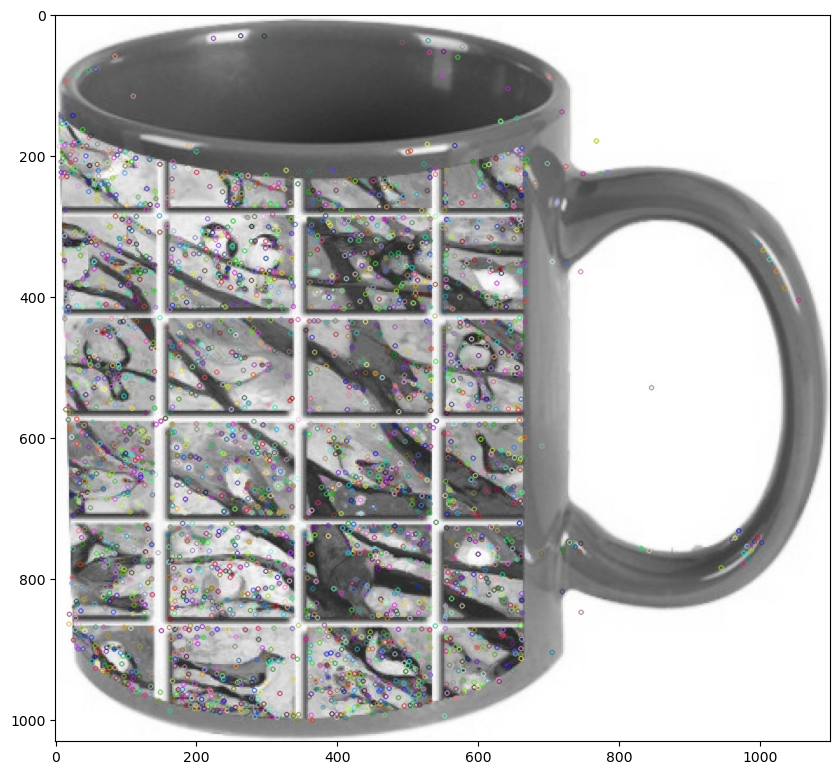

In [189]:

# Lire l'image avec les keypoints
sift_image = cv2.imread('sift_keypoints.jpg')

# Convertir l'image en RGB pour l'affichage avec matplotlib
sift_image = cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(sift_image)
plt.show()

#### 3.2.2 Extraction des Descripteurs SIFT pour Toutes les Images


In [192]:
data.size

10500

In [194]:

# Fonction d'extraction de descripteurs SIFT
def extract_sift_descriptors(image_paths):
    sift = cv2.SIFT_create()
    sift_features = []
    for image_path in image_paths:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            keypoints, descriptors = sift.detectAndCompute(image, None)
            if descriptors is not None:
                sift_features.append(descriptors.astype(np.float32))
            else:
                sift_features.append(np.zeros((0, 128), dtype=np.float32))
    return sift_features

# Chemin du dossier contenant toutes les images
image_folder_path = r'C:\Users\SOUKA\Documents\Images'

# Charger les chemins d'images
image_paths = [os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path)]

# Extraire les descripteurs SIFT
sift_features = extract_sift_descriptors(image_paths)

In [196]:
sift_features

[array([[ 11.,   1.,   2., ...,   0.,   0.,   0.],
        [  8.,   2.,   0., ...,   1.,   1.,   7.],
        [ 54.,  20.,   1., ...,   0.,   0.,   2.],
        ...,
        [  3., 100.,  33., ...,   0.,   0.,  23.],
        [ 29.,   9.,   1., ...,   0.,   0.,   0.],
        [ 10.,  10.,   1., ...,   0.,   0.,   0.]], dtype=float32),
 array([[31.,  1.,  0., ...,  0.,  0.,  0.],
        [69.,  6.,  0., ...,  0.,  0.,  2.],
        [ 0.,  0.,  0., ...,  0.,  0.,  2.],
        ...,
        [20.,  1.,  0., ...,  0.,  0.,  5.],
        [50.,  3.,  0., ...,  0.,  0.,  2.],
        [19.,  2.,  0., ...,  0.,  0.,  5.]], dtype=float32),
 array([[  0.,  33., 172., ...,   0.,   0.,   1.],
        [  6.,   7.,  13., ...,   0.,   0.,   3.],
        [  0.,  21.,  32., ...,   0.,   0.,   3.],
        ...,
        [  1.,   1.,   4., ...,   0.,   0.,   1.],
        [  6.,   3.,   2., ...,   0.,   0.,   0.],
        [  6.,   1.,   1., ...,   0.,   0.,   0.]], dtype=float32),
 array([[ 6.,  1.,  0., ...,

#### 3.2.3 Clustering des Descripteurs SIFT avec KMeans
Concaténez tous les descripteurs SIFT et effectuez un clustering avec KMeans :


Réduisez la dimension des histogrammes avec PCA puis t-SNE pour une visualisation en 2D :

In [ ]:
sift_features

Étape 1 : Diviser les Descripteurs en Lots

Pour éviter des problèmes de mémoire, nous pouvons diviser les descripteurs en plusieurs lots avant de les concaténer. Voici comment procéder :

In [198]:
# Diviser les descripteurs SIFT en lots
def split_into_batches(descriptors_list, batch_size):
    batches = []
    batch = []
    total_size = 0
    for descriptors in descriptors_list:
        batch.append(descriptors)
        total_size += descriptors.shape[0]
        if total_size >= batch_size:
            batches.append(np.vstack(batch))
            batch = []
            total_size = 0
    if batch:
        batches.append(np.vstack(batch))
    return batches

# Définir la taille du lot en fonction de la mémoire disponible
batch_size = 100000  # Ajustez selon vos ressources
batches = split_into_batches(sift_features, batch_size)

Étape 2 : Standardiser les Descripteurs SIFT
Appliquez la standardisation à chaque lot de descripteurs et concaténez les résultats.

In [206]:
def standardize_batches(batches):
    scaler = StandardScaler()
    standardized_batches = []
    for batch in batches:
        standardized_batch = scaler.fit_transform(batch)
        standardized_batches.append(standardized_batch)
    return np.concatenate(standardized_batches, axis=0)

sift_features_scaled = standardize_batches(batches)

Étape 3 : Réduction de Dimensionnalité avec PCA
Réduisez la dimensionnalité des descripteurs SIFT standardisés.

In [209]:
# Appliquer PCA
pca = PCA(n_components=2)  # Réduction à 2 dimensions
pca_result = pca.fit_transform(sift_features_scaled)

Étape 4 : Réduction de Dimensionnalité avec t-SNE
Utilisez t-SNE sur les résultats PCA pour la visualisation en 2D.

In [212]:
# Échantillonner un sous-ensemble des données pour t-SNE
sample_size = min(10000, pca_result.shape[0])  # Ajustez la taille de l'échantillon selon vos besoins
indices = np.random.choice(pca_result.shape[0], sample_size, replace=False)
pca_result_sampled = pca_result[indices]

In [214]:
# Appliquer t-SNE sur l'échantillon
tsne = TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=30)
tsne_result = tsne.fit_transform(pca_result_sampled)

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Étape 5 : Clustering avec KMeans
Appliquez KMeans pour le clustering.

In [217]:
# Clustering avec KMeans
kmeans = MiniBatchKMeans(n_clusters=7, batch_size=10000, random_state=42)
kmeans.fit(pca_result)
cluster_labels = kmeans.labels_

Étape 6 : Visualisation des Résultats
Visualisez les résultats avec t-SNE et KMeans.

In [220]:
# Charger les catégories réelles
real_categories = data['main_category'].values  # Remplacez par la colonne appropriée

In [222]:
print(f"Shape of tsne_result: {tsne_result.shape}")
print(f"Length of real_categories: {len(real_categories)}")

Shape of tsne_result: (10000, 2)
Length of real_categories: 1050


In [224]:
# Ajustez la taille de l'échantillon pour correspondre à la plus petite taille
sample_size = min(len(real_categories), tsne_result.shape[0])
sample_size

1050

In [226]:
# Choisir des indices pour échantillonner de manière cohérente
indices = np.random.choice(len(real_categories), sample_size, replace=False)

In [228]:
# Échantillonner `real_categories` et `tsne_result`
real_categories_sampled = real_categories[indices]
tsne_result_sampled = tsne_result[indices]
cluster_labels_sampled = cluster_labels[indices]

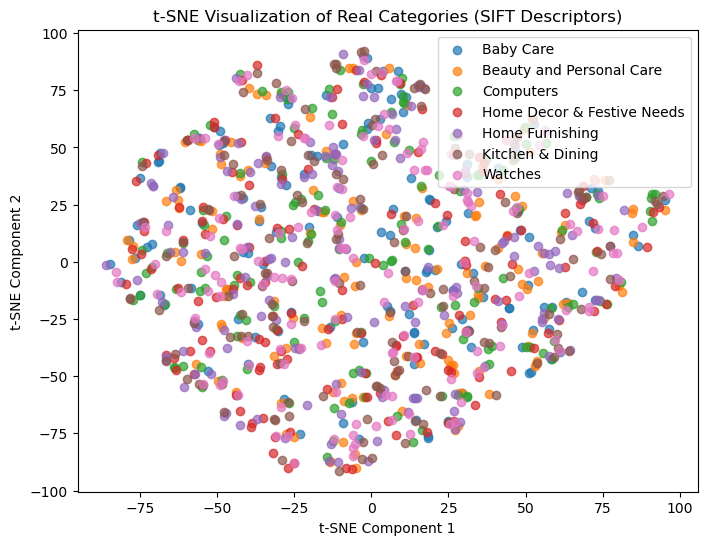

In [230]:
# Visualisation des résultats t-SNE avec les catégories réelles
plt.figure(figsize=(8, 6))
for category in np.unique(real_categories_sampled):
    idx = real_categories_sampled == category
    plt.scatter(tsne_result_sampled[idx, 0], tsne_result_sampled[idx, 1], label=category, alpha=0.7)
plt.title("t-SNE Visualization of Real Categories (SIFT Descriptors)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

C:\Users\SOUKA\AppData\Local\Temp\ipykernel_7152\3587430973.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(unique_clusters))  # 'tab10' fournit 10 couleurs discrètes


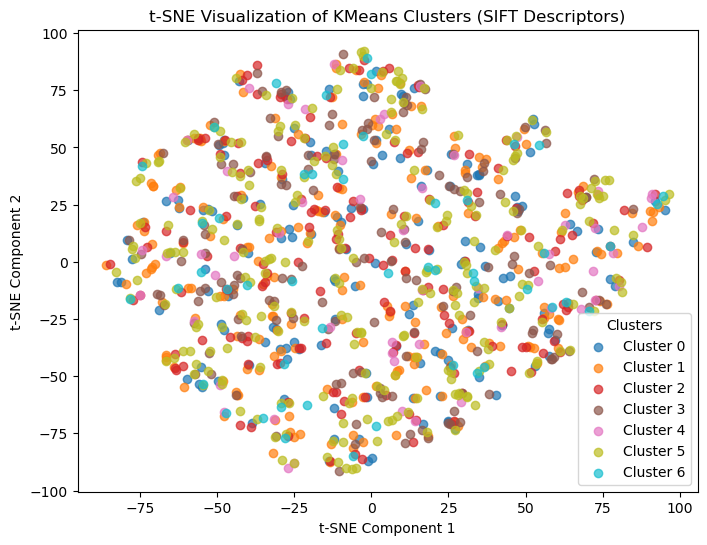

In [232]:
# Bibliothèque pour les couleurs discrètes
from matplotlib import cm

# Définir une palette de couleurs discrètes pour chaque cluster
unique_clusters = np.unique(cluster_labels_sampled)
colors = cm.get_cmap('tab10', len(unique_clusters))  # 'tab10' fournit 10 couleurs discrètes

# Visualisation des résultats t-SNE avec les clusters KMeans sans échelle de couleur
plt.figure(figsize=(8, 6))
for cluster in unique_clusters:
    idx = cluster_labels_sampled == cluster
    plt.scatter(tsne_result_sampled[idx, 0], tsne_result_sampled[idx, 1], 
                color=colors(cluster), label=f"Cluster {cluster}", alpha=0.7)

plt.title("t-SNE Visualization of KMeans Clusters (SIFT Descriptors)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Clusters")
plt.show()

In [236]:
# Calcul du score ARI entre les catégories réelles et les clusters KMeans échantillonnés
ari_score = adjusted_rand_score(real_categories_sampled, cluster_labels_sampled)
print(f"Adjusted Rand Index (ARI) between real categories and KMeans clusters: {ari_score}")

Adjusted Rand Index (ARI) between real categories and KMeans clusters: 0.0019385824404114119


** Conclusion **
  **********

Un Adjusted Rand Index (ARI) aussi bas que 0.0019 indique que les clusters générés par KMeans sont pratiquement aléatoires par rapport aux catégories réelles. Cela signifie que le modèle de clustering basé sur les descripteurs SIFT n'a pas réussi à bien séparer les images selon les catégories réelles.


Explication : 

Les descripteurs SIFT ne capturent pas bien les caractéristiques distinctives des catégories :
   
SIFT (Scale-Invariant Feature Transform) est un algorithme qui excelle dans l'identification de points d'intérêt localisés dans une image. Cependant, il est particulièrement adapté aux images présentant des textures ou des caractéristiques visuelles locales distinctes (comme les coins ou les bords).

Si les images des différentes catégories dans votre dataset ne sont pas suffisamment discriminantes à un niveau local (par exemple, si elles contiennent des objets similaires ou des textures lisses), SIFT peut avoir du mal à différencier les images.



In [239]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder


In [241]:
# Encodage des catégories réelles (si nécessaire)
le = LabelEncoder()
labels = le.fit_transform(data['main_category'])  # Encode the 'main_category' as integer labels


In [243]:
# Nombre de clusters
k = 7  # Assurez-vous que c'est bien le nombre de clusters prévus

In [247]:
# Utilisation des étiquettes de cluster obtenues via MiniBatchKMeans
clusters = cluster_labels  # 'cluster_labels' a été généré avec MiniBatchKMeans

In [251]:
# Synchronisation des clusters et des catégories réelles
sample_size = len(labels)  # Taille des catégories réelles (1050)
clusters_sampled = cluster_labels[:sample_size]  # Réduire la taille des clusters pour correspondre

# Calcul de la matrice de confusion après synchronisation
conf_mat = confusion_matrix(labels, clusters_sampled)
print("Matrice de confusion après synchronisation :\n", conf_mat)

Matrice de confusion après synchronisation :
 [[24 28 25 20  8 35 10]
 [28 28 27 19  9 35  4]
 [22 26 31 27  6 37  1]
 [18 49 20 18  2 39  4]
 [19 31 22 26  5 40  7]
 [25 32 19 18 15 32  9]
 [21 23 26 25 12 29 14]]


In [253]:
# Création d'une correspondance fictive pour transformation
corresp = list(range(7))  # Correspondance fictive pour les clusters

In [255]:
# Fonction de transformation des clusters
def conf_mat_transform(y_true, y_pred):
    # Transformer les clusters prédits en utilisant la correspondance fictive
    labels_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    labels_df['y_pred_transform'] = labels_df['y_pred'].apply(lambda x: corresp[x])
    return labels_df['y_pred_transform']

In [259]:
# Appliquer la transformation sur les clusters échantillonnés
clusters_transformed = conf_mat_transform(labels, clusters_sampled)

# Afficher les clusters originaux et transformés pour vérification
print(f"Clusters d'origine : {clusters_sampled[:10]}")
print(f"Clusters transformés : {clusters_transformed[:10].tolist()}")

Clusters d'origine : [4 4 6 6 0 4 6 4 4 6]
Clusters transformés : [4, 4, 6, 6, 0, 4, 6, 4, 4, 6]


In [261]:
# Recalculer la matrice de confusion après transformation
conf_mat_transformed = confusion_matrix(labels, clusters_transformed)
print("Matrice de confusion après transformation :\n", conf_mat_transformed)

# Générer et afficher le rapport de classification
classification_rep = classification_report(labels, clusters_transformed, zero_division=0)
print("Rapport de classification :\n", classification_rep)

Matrice de confusion après transformation :
 [[24 28 25 20  8 35 10]
 [28 28 27 19  9 35  4]
 [22 26 31 27  6 37  1]
 [18 49 20 18  2 39  4]
 [19 31 22 26  5 40  7]
 [25 32 19 18 15 32  9]
 [21 23 26 25 12 29 14]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.15      0.16      0.16       150
           1       0.13      0.19      0.15       150
           2       0.18      0.21      0.19       150
           3       0.12      0.12      0.12       150
           4       0.09      0.03      0.05       150
           5       0.13      0.21      0.16       150
           6       0.29      0.09      0.14       150

    accuracy                           0.14      1050
   macro avg       0.15      0.14      0.14      1050
weighted avg       0.15      0.14      0.14      1050



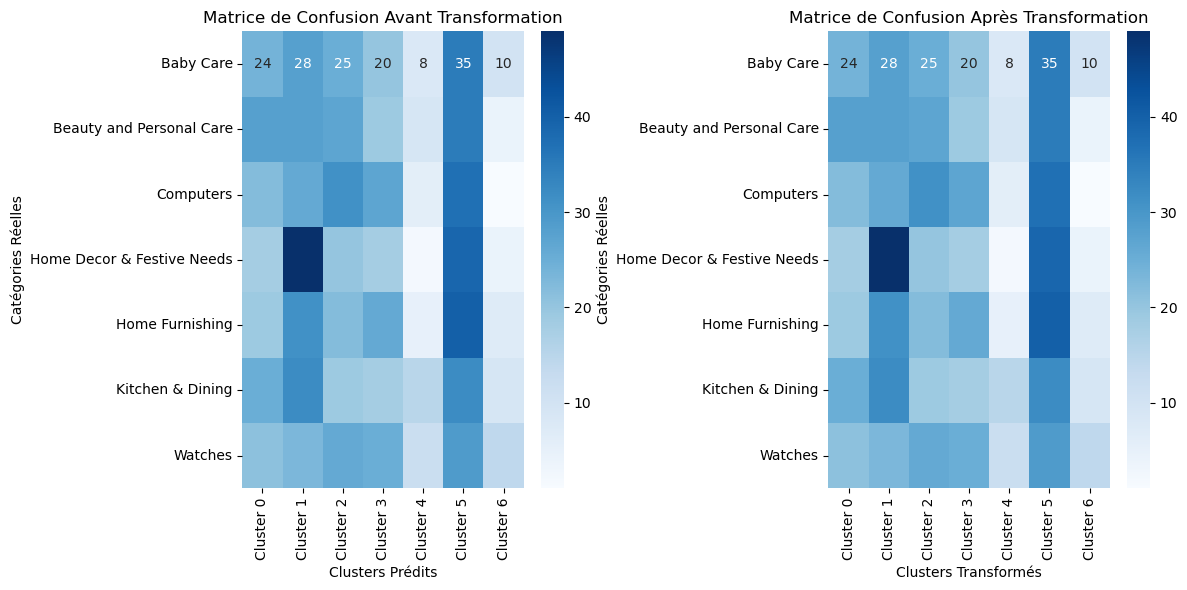

In [263]:
# Assurez-vous que les matrices de confusion ont été calculées
# df_cm_before représente la matrice avant transformation des clusters
# df_cm_after représente la matrice après transformation des clusters

# Création des DataFrames pour les heatmaps
df_cm_before = pd.DataFrame(conf_mat, 
                            index=[f'{cat}' for cat in le.classes_],  # Utilise les classes réelles
                            columns=[f'Cluster {i}' for i in range(conf_mat.shape[1])])  # Assurez-vous que le nombre de clusters est correct

df_cm_after = pd.DataFrame(conf_mat_transformed, 
                           index=[f'{cat}' for cat in le.classes_],  # Les mêmes classes réelles
                           columns=[f'Cluster {i}' for i in range(conf_mat_transformed.shape[1])])  # Nombre de clusters après transformation

# Création des heatmaps
plt.figure(figsize=(12, 6))

# Heatmap avant transformation
plt.subplot(1, 2, 1)
sns.heatmap(df_cm_before, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.title("Matrice de Confusion Avant Transformation")
plt.ylabel('Catégories Réelles')
plt.xlabel('Clusters Prédits')

# Heatmap après transformation
plt.subplot(1, 2, 2)
sns.heatmap(df_cm_after, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.title("Matrice de Confusion Après Transformation")
plt.ylabel('Catégories Réelles')
plt.xlabel('Clusters Transformés')

plt.tight_layout()
plt.show()

## Étape 4 : Étudiez la faisabilité de classification automatique en utilisant des techniques de traitement d'image plus avancées

Utilisation de Réseaux de Neurones Pré-entraînés :

Chargement de modèles pré-entraînés comme VGG16, ResNet50, ou InceptionV3.

Extraction de Features Avancées :

Utilisation des couches intermédiaires des réseaux de neurones pour extraire des features avancées.

Réduction de Dimension :

Application de PCA ou t-SNE sur les features extraites.

Comparaison avec les Méthodes Basiques :

Comparaison des résultats obtenus avec ceux des méthodes basiques.

In [265]:
# Importer les librairies
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE  # Importation du t-SNE
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [267]:
# Chemins
image_folder_path = r'C:\Users\SOUKA\Documents\Images'
data = pd.read_csv('data.csv')
image_paths = data['image'].values
categories = data['main_category'].values

In [269]:
# Charger le modèle VGG16 pré-entraîné sans la dernière couche de classification
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

In [271]:
# Prétraitement des images pour VGG16
def preprocess_image_vgg16(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: l'image à '{image_path}' n'a pas pu être chargée.")
        return None
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

In [273]:
# Prétraiter et extraire les features
valid_images = []
valid_categories = []

for img_path, cat in zip(image_paths, categories):
    img = preprocess_image_vgg16(os.path.join(image_folder_path, img_path))
    if img is not None:
        img = np.expand_dims(img, axis=0)  # Ajouter une dimension pour le batch
        features = model.predict(img)
        features = features.flatten()
        valid_images.append(features)
        valid_categories.append(cat)

valid_images = np.array(valid_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

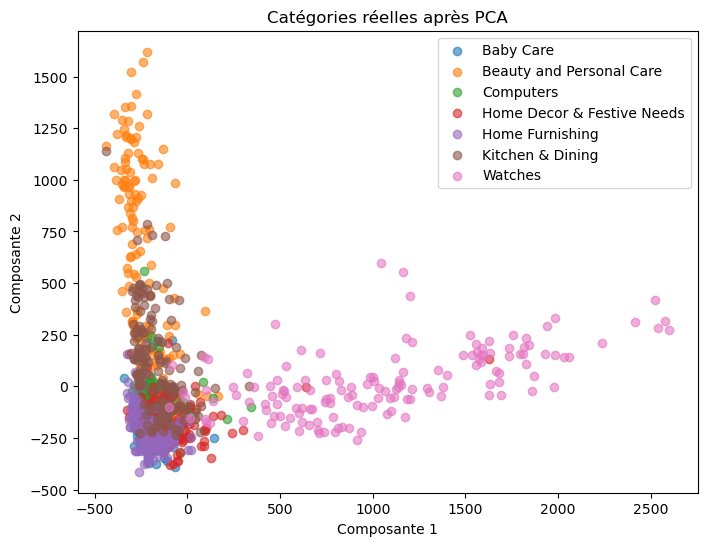

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


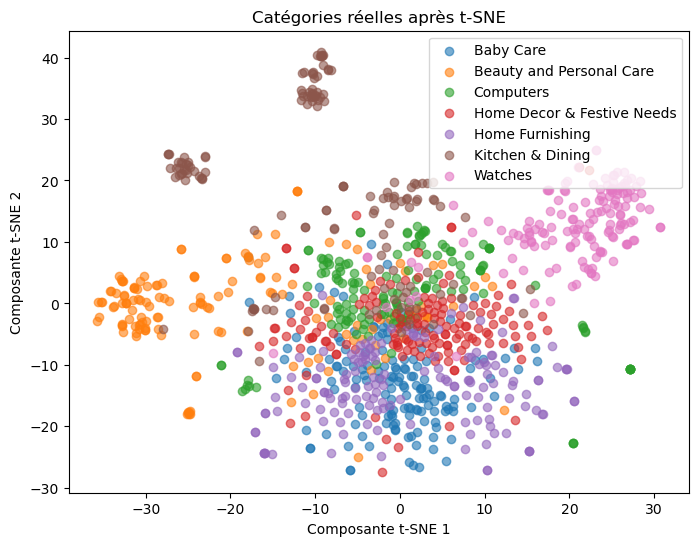

In [274]:
# Encodage des catégories réelles avec LabelEncoder
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(data['main_category'])

# Récupérer les noms des catégories uniques
category_names = label_encoder.classes_

# Réduction de dimension avec PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(valid_images)

# Visualisation des catégories réelles avec PCA
plt.figure(figsize=(8, 6))
for i, category_name in enumerate(category_names):  # Pour chaque catégorie réelle avec son nom
    plt.scatter(features_pca[categories_encoded == i, 0], features_pca[categories_encoded == i, 1], label=category_name, alpha=0.6)

plt.title('Catégories réelles après PCA')
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.legend()
plt.show()

# Application du t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(valid_images)

# Visualisation des catégories réelles avec t-SNE
plt.figure(figsize=(8, 6))
for i, category_name in enumerate(category_names):  # Pour chaque catégorie réelle avec son nom
    plt.scatter(features_tsne[categories_encoded == i, 0], features_tsne[categories_encoded == i, 1], label=category_name, alpha=0.6)

plt.title('Catégories réelles après t-SNE')
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')
plt.legend()
plt.show()

In [279]:
# Paramètres KMeans
k = 7
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000)

In [281]:
# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(valid_categories)

In [283]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(valid_images)

In [285]:
# Appliquer K-Means après PCA
kmeans_pca_labels = kmeans.fit_predict(features_pca)

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=5
  warnings.warn(


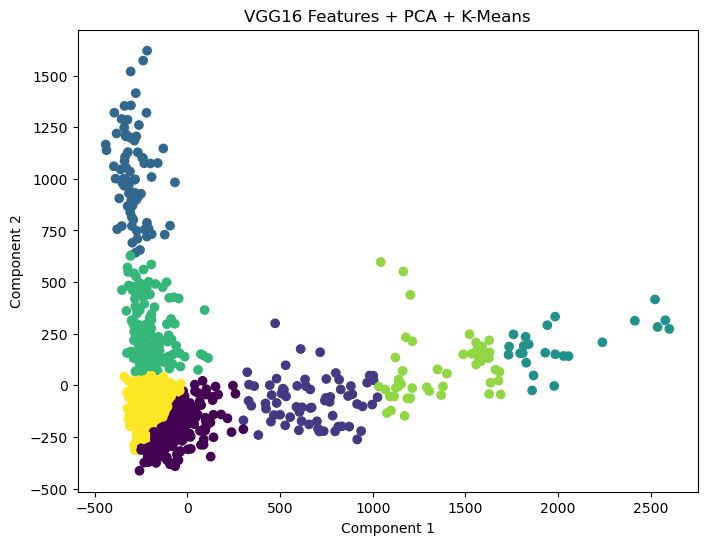

In [287]:
# Visualisation PCA
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_pca_labels, cmap='viridis')
plt.title('VGG16 Features + PCA + K-Means')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [289]:
# Application du t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(valid_images)

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [290]:
# Appliquer K-Means après t-SNE
kmeans_tsne_labels = kmeans.fit_predict(features_tsne)

C:\Users\SOUKA\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1848: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=5
  warnings.warn(


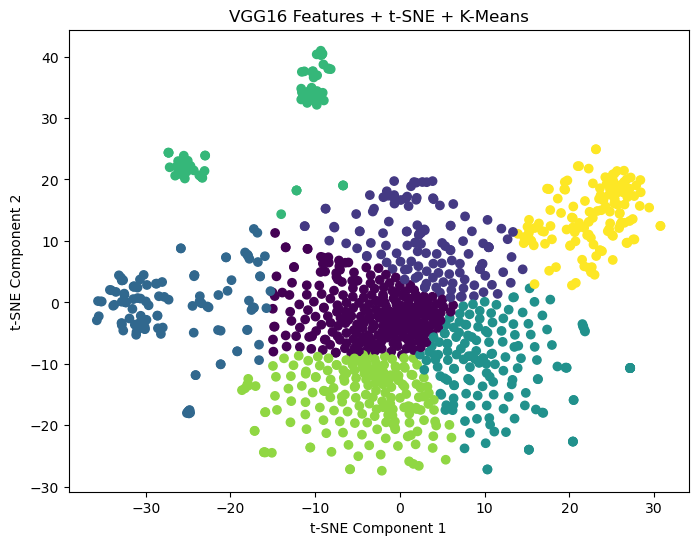

In [293]:
# Visualisation t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_tsne_labels, cmap='viridis')
plt.title('VGG16 Features + t-SNE + K-Means')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [295]:
# Calcul des métriques pour PCA
silhouette_pca = silhouette_score(features_pca, kmeans_pca_labels)
db_index_pca = davies_bouldin_score(features_pca, kmeans_pca_labels)
ari_pca = adjusted_rand_score(categories_encoded, kmeans_pca_labels)

# Calcul des métriques pour t-SNE
silhouette_tsne = silhouette_score(features_tsne, kmeans_tsne_labels)
db_index_tsne = davies_bouldin_score(features_tsne, kmeans_tsne_labels)
ari_tsne = adjusted_rand_score(categories_encoded, kmeans_tsne_labels)

# Affichage des résultats
print(f"VGG16 Features + PCA - Silhouette Score: {silhouette_pca}")
print(f"VGG16 Features + PCA - Davies-Bouldin Index: {db_index_pca}")
print(f"VGG16 Features + PCA - ARI: {ari_pca}")

print(f"VGG16 Features + t-SNE - Silhouette Score: {silhouette_tsne}")
print(f"VGG16 Features + t-SNE - Davies-Bouldin Index: {db_index_tsne}")
print(f"VGG16 Features + t-SNE - ARI: {ari_tsne}")

VGG16 Features + PCA - Silhouette Score: 0.3583625257015228
VGG16 Features + PCA - Davies-Bouldin Index: 0.8266616269240176
VGG16 Features + PCA - ARI: 0.16360134237844093
VGG16 Features + t-SNE - Silhouette Score: 0.3930359482765198
VGG16 Features + t-SNE - Davies-Bouldin Index: 0.8078279175546313
VGG16 Features + t-SNE - ARI: 0.3282783500316887


** Interpréation et conclusion **
**********

Comparaison des Résultats :

Performances du Clustering avec t-SNE pour SIFT vs VGG16 :

ARI pour SIFT avec t-SNE : Très faible (0.0019)

ARI pour VGG16 avec t-SNE : Significativement plus élevé (0.3283)

Analyse des Résultats

Qualité des Caractéristiques Extraites :

SIFT avec t-SNE : Même après l'application de t-SNE pour réduire la dimensionnalité, les caractéristiques SIFT semblent ne pas capturer suffisamment de détails discriminants pour permettre un bon regroupement en clusters. Cela suggère que les points d'intérêt locaux détectés par SIFT ne sont pas suffisamment informatifs pour la tâche de classification, même après réduction dimensionnelle.

VGG16 avec t-SNE : Les caractéristiques extraites par le modèle VGG16, même après réduction dimensionnelle par t-SNE, montrent une meilleure correspondance avec les catégories réelles. Cela indique que les caractéristiques globales et complexes capturées par le réseau convolutif sont plus représentatives et utiles pour la classification.

Capacité de Représentation des Données :

SIFT : Bien que SIFT soit efficace pour détecter des points d'intérêt et des descripteurs locaux, il peut ne pas capturer des relations complexes et globales entre les différentes parties d'une image. Les descripteurs locaux peuvent manquer de contexte global, ce qui limite leur utilité pour le clustering et la classification lorsque les relations entre différentes régions de l'image sont importantes.

VGG16 : Les réseaux de neurones convolutifs comme VGG16 sont conçus pour capturer des caractéristiques à différents niveaux de complexité, y compris des informations globales et contextuelles. Cela rend les caractéristiques extraites plus adaptées aux tâches de clustering et de classification, car elles capturent des motifs plus globaux et significatifs dans les images.

Efficacité des Techniques de Réduction Dimensionnelle :

SIFT avec t-SNE : Même si t-SNE est efficace pour visualiser des données en haute dimension en 2D, le fait que les caractéristiques SIFT soient de faible qualité peut limiter l'efficacité du t-SNE à révéler des structures significatives.

VGG16 avec t-SNE : La qualité des caractéristiques extraites par VGG16 rend le t-SNE plus efficace pour révéler des structures et des relations importantes entre les données, améliorant ainsi les résultats du clustering.

Interprétation Pratique :

SIFT : Peut être utile pour des tâches spécifiques où les détails locaux sont cruciaux, mais peut ne pas être suffisant pour des tâches de classification complexes qui nécessitent une compréhension plus globale des images.

VGG16 : Fournit des caractéristiques riches et globales qui sont plus adaptées aux tâches de classification et de clustering complexes, surtout lorsque les relations contextuelles et les structures globales dans les images sont importantes.

Conclusion
Les résultats montrent que les caractéristiques extraites par VGG16, même après réduction dimensionnelle avec t-SNE, sont nettement plus efficaces pour le clustering que les caractéristiques SIFT. Cela souligne la supériorité des approches modernes basées sur des réseaux de neurones pour capturer des informations pertinentes dans les images, ce qui est crucial pour des tâches complexes de classification et de clustering.

In [ ]:
Étape 1 : Créer la matrice de confusion pour les résultats de K-Means

In [297]:
from sklearn.metrics import confusion_matrix, classification_report

# Matrice de confusion pour PCA
conf_mat_pca = confusion_matrix(categories_encoded, kmeans_pca_labels)
print("Matrice de confusion pour VGG16 + PCA + K-Means :\n", conf_mat_pca)

# Matrice de confusion pour t-SNE
conf_mat_tsne = confusion_matrix(categories_encoded, kmeans_tsne_labels)
print("Matrice de confusion pour VGG16 + t-SNE + K-Means :\n", conf_mat_tsne)

# Rapport de classification pour PCA
classification_rep_pca = classification_report(categories_encoded, kmeans_pca_labels, target_names=category_names, zero_division=0)
print("Rapport de classification pour VGG16 + PCA + K-Means :\n", classification_rep_pca)

# Rapport de classification pour t-SNE
classification_rep_tsne = classification_report(categories_encoded, kmeans_tsne_labels, target_names=category_names, zero_division=0)
print("Rapport de classification pour VGG16 + t-SNE + K-Means :\n", classification_rep_tsne)

Matrice de confusion pour VGG16 + PCA + K-Means :
 [[ 67   0   0   0   4   0  79]
 [ 15   0  70   0  48   0  17]
 [ 29   1   0   0   5   0 115]
 [ 84   1   0   0   4   1  60]
 [ 73   0   0   0   3   0  74]
 [ 22   1   5   0  74   0  48]
 [ 10  65   0  24   3  47   1]]
Matrice de confusion pour VGG16 + t-SNE + K-Means :
 [[ 27   3   2  21   0  97   0]
 [ 26  10 101   1   3   9   0]
 [ 76  49   2  15   0   7   1]
 [ 76  11   1  51   0   9   2]
 [ 20   0   2  63   0  65   0]
 [ 20  42  10   3  75   0   0]
 [  4  14   0   3   0   0 129]]
Rapport de classification pour VGG16 + PCA + K-Means :
                             precision    recall  f1-score   support

                 Baby Care       0.22      0.45      0.30       150
  Beauty and Personal Care       0.00      0.00      0.00       150
                 Computers       0.00      0.00      0.00       150
Home Decor & Festive Needs       0.00      0.00      0.00       150
           Home Furnishing       0.02      0.02      0.02      

Étape 2 : Visualiser les matrices de confusion sous forme de heatmap

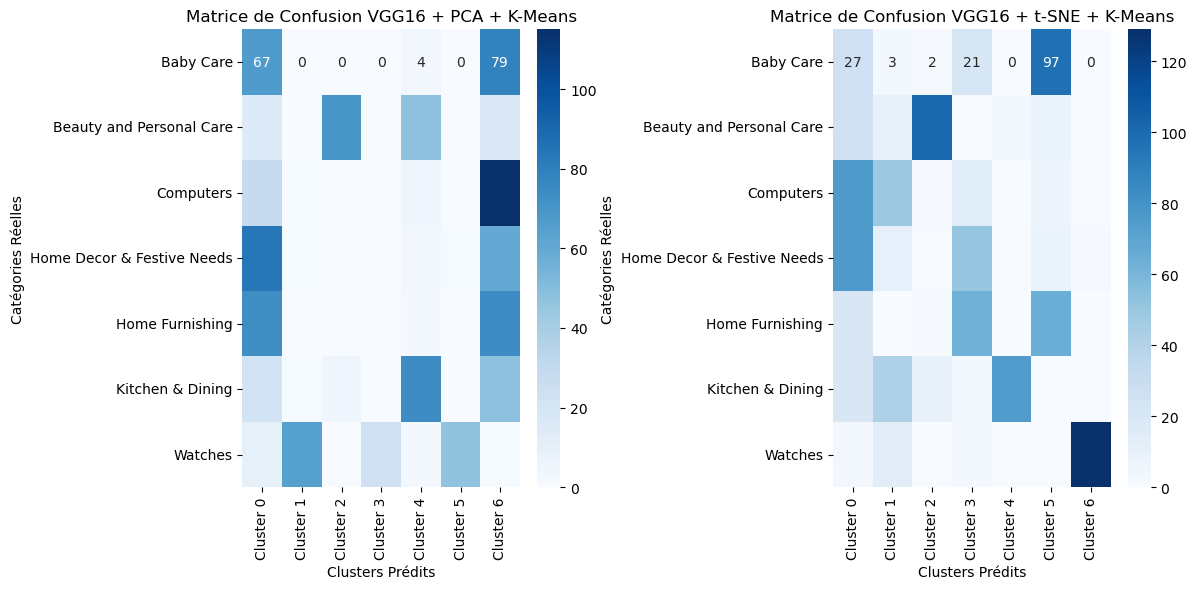

In [302]:
# Création des DataFrames pour les heatmaps (PCA et t-SNE)
df_cm_pca = pd.DataFrame(conf_mat_pca, 
                         index=[f'{cat}' for cat in category_names],
                         columns=[f'Cluster {i}' for i in range(k)])

df_cm_tsne = pd.DataFrame(conf_mat_tsne, 
                          index=[f'{cat}' for cat in category_names],
                          columns=[f'Cluster {i}' for i in range(k)])

# Visualisation de la matrice de confusion pour PCA
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(df_cm_pca, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.title("Matrice de Confusion VGG16 + PCA + K-Means")
plt.xlabel('Clusters Prédits')
plt.ylabel('Catégories Réelles')

# Visualisation de la matrice de confusion pour t-SNE
plt.subplot(1, 2, 2)
sns.heatmap(df_cm_tsne, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.title("Matrice de Confusion VGG16 + t-SNE + K-Means")
plt.xlabel('Clusters Prédits')
plt.ylabel('Catégories Réelles')

plt.tight_layout()
plt.show()